## Import packages

In [4]:
import sys
print(sys.version)

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from datetime import datetime

import pandas as pd
import rasterio
import onnx

3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:18:29) [MSC v.1929 64 bit (AMD64)]


## Import the tabular data

In [98]:
buffalo_id = 2005
n_samples = 10297 # 2005 has 10297 samples

# buffalo_id = 2018
# n_samples = 9440 # 2018 has 9440 samples

# Specify the path to your CSV file
csv_file_path = f'../buffalo_local_data_id/buffalo_{buffalo_id}_data_df_lag_1hr_n{n_samples}.csv'

# Read the CSV file into a DataFrame
buffalo_df = pd.read_csv(csv_file_path)
print(buffalo_df.shape)

# Lag the values in column 'A' by one index
buffalo_df['bearing_tm1'] = buffalo_df['bearing'].shift(1)
# Pad the missing value with a specified value, e.g., 0
buffalo_df['bearing_tm1'] = buffalo_df['bearing_tm1'].fillna(0)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

(10103, 32)
             x_            y_                    t_    id           x1_  \
0  41969.310875 -1.435671e+06  2018-07-25T01:04:23Z  2005  41969.310875   
1  41921.521939 -1.435654e+06  2018-07-25T02:04:39Z  2005  41921.521939   
2  41779.439594 -1.435601e+06  2018-07-25T03:04:17Z  2005  41779.439594   
3  41841.203272 -1.435635e+06  2018-07-25T04:04:39Z  2005  41841.203272   
4  41655.463332 -1.435604e+06  2018-07-25T05:04:27Z  2005  41655.463332   

            y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0 -1.435671e+06  41921.521939 -1.435654e+06  -47.788936  16.857110  ...   
1 -1.435654e+06  41779.439594 -1.435601e+06 -142.082345  53.568427  ...   
2 -1.435601e+06  41841.203272 -1.435635e+06   61.763677 -34.322938  ...   
3 -1.435635e+06  41655.463332 -1.435604e+06 -185.739939  31.003534  ...   
4 -1.435604e+06  41618.651923 -1.435608e+06  -36.811409  -4.438037  ...   

  bearing_sin  bearing_cos        ta    cos_ta         x_min         x_max  \
0    0.3

## Importing spatial data

## NDVI

In [6]:
file_path = '../buffalo_local_layers_id/buffalo_2005_ndvi_cent101x101_lag_1hr_n10297.tif'

# Using rasterio 
with rasterio.open(file_path) as ndvi:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    ndvi_stack = ndvi.read([i for i in range(1, ndvi.count + 1)])


In [7]:
print(ndvi_stack.shape)
# print(ndvi_stack.size)

ndvi_tens = torch.from_numpy(ndvi_stack)
print(ndvi_tens.shape)
print("Mean = ", torch.mean(ndvi_tens))

ndvi_max = torch.max(ndvi_tens)
ndvi_min = torch.min(ndvi_tens)

print("Max = ", ndvi_max)
print("Min = ", ndvi_min)

# Normalizing the data
ndvi_tens_norm = (ndvi_tens - ndvi_min) / (ndvi_max - ndvi_min)
print("Mean = ", torch.mean(ndvi_tens_norm))
print("Max = ", torch.max(ndvi_tens_norm))
print("Min = ", torch.min(ndvi_tens_norm))

# print(ndvi_tens_norm.dtype)


(10103, 101, 101)
torch.Size([10103, 101, 101])
Mean =  tensor(0.3039)
Max =  tensor(0.8220)
Min =  tensor(-0.2772)
Mean =  tensor(0.5287)
Max =  tensor(1.)
Min =  tensor(0.)


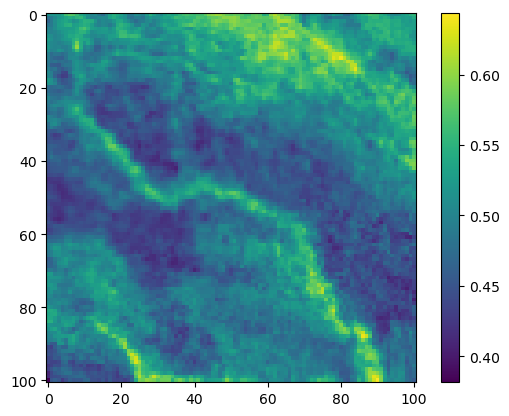

In [8]:
for i in range(0, 1):
    plt.imshow(ndvi_tens_norm[i].numpy())
    plt.colorbar()  
    plt.show()

## Canopy cover

In [9]:
# Path to your TIF file
file_path = '../buffalo_local_layers_id/buffalo_2005_canopy_cent101x101_lag_1hr_n10297.tif'
# with lag
# file_path = '../synthetic_canopy_cent100x100_lag_6hr_n10000.tif'

# Using rasterio 
with rasterio.open(file_path) as canopy:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    canopy_stack = canopy.read([i for i in range(1, canopy.count + 1)])

# print(canopy_se)

In [10]:
print(canopy_stack.shape)
# print(canopy_stack.size)

canopy_tens = torch.from_numpy(canopy_stack)
print(canopy_tens.shape)
print("Mean = ", torch.mean(canopy_tens))

canopy_max = torch.max(canopy_tens)
canopy_min = torch.min(canopy_tens)

print("Max = ", canopy_max)
print("Min = ", canopy_min)

# Normalizing the data
canopy_tens_norm = (canopy_tens - canopy_min) / (canopy_max - canopy_min)
print("Mean = ", torch.mean(canopy_tens_norm))
print("Max = ", torch.max(canopy_tens_norm))
print("Min = ", torch.min(canopy_tens_norm))

# print(canopy_tens_norm.dtype)

(10103, 101, 101)
torch.Size([10103, 101, 101])
Mean =  tensor(44.3548)
Max =  tensor(82.5000)
Min =  tensor(0.)
Mean =  tensor(0.5376)
Max =  tensor(1.)
Min =  tensor(0.)


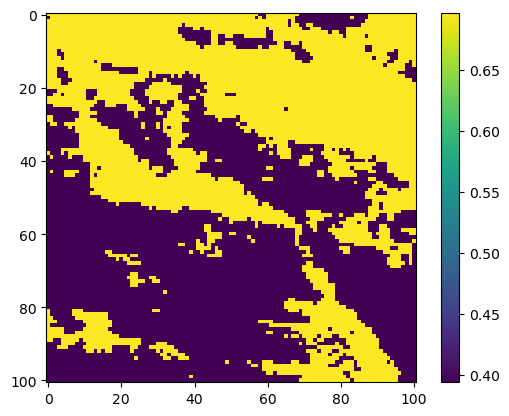

In [11]:
for i in range(0, 1):
    plt.imshow(canopy_tens_norm[i].numpy())
    plt.colorbar()  
    plt.show()

## Herbaceous vegetation

In [12]:
# Path to your TIF file
file_path = '../buffalo_local_layers_id/buffalo_2005_herby_cent101x101_lag_1hr_n10297.tif'
# with lag
# file_path = '../synthetic_herby_cent100x100_lag_6hr_n10000.tif'

# Using rasterio 
with rasterio.open(file_path) as herby:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    herby_stack = herby.read([i for i in range(1, herby.count + 1)])

# print(herby_stack.shape)      

In [13]:
print(herby_stack.shape)
# print(canopy_stack.size)

herby_tens = torch.from_numpy(herby_stack)
print(herby_tens.shape)
print("Mean = ", torch.mean(herby_tens))

herby_max = torch.max(herby_tens)
herby_min = torch.min(herby_tens)

print("Max = ", herby_max)
print("Min = ", herby_min)

# Normalizing the data
herby_tens_norm = (herby_tens - herby_min) / (herby_max - herby_min)
print("Mean = ", torch.mean(herby_tens_norm))
print("Max = ", torch.max(herby_tens_norm))
print("Min = ", torch.min(herby_tens_norm))

# print(herby_tens_norm.dtype)

(10103, 101, 101)
torch.Size([10103, 101, 101])
Mean =  tensor(0.8069)
Max =  tensor(1.)
Min =  tensor(0.)
Mean =  tensor(0.8069)
Max =  tensor(1.)
Min =  tensor(0.)


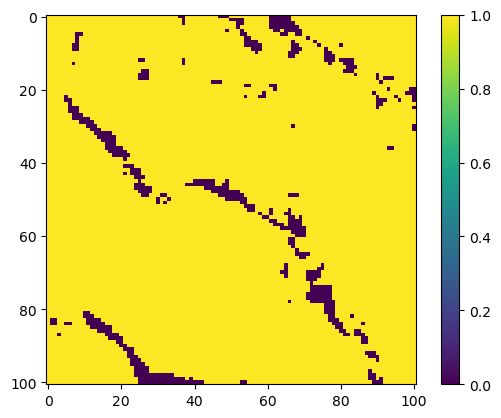

In [14]:
for i in range(0, 1):
    plt.imshow(herby_tens_norm[i])
    plt.colorbar()  
    plt.show()

## Slope

In [15]:
# Path to your TIF file
file_path = '../buffalo_local_layers_id/buffalo_2005_slope_cent101x101_lag_1hr_n10297.tif'
# with lag
# file_path = '../synthetic_slope_cent100x100_lag_6hr_n10000.tif'

# Using rasterio 
with rasterio.open(file_path) as slope:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    slope_stack = slope.read([i for i in range(1, slope.count + 1)])

print(slope_stack.shape)

(10103, 101, 101)


In [16]:
print(slope_stack.shape)
# print(canopy_stack.size)

slope_tens = torch.from_numpy(slope_stack)
print(slope_tens.shape)
print("Mean = ", torch.mean(slope_tens))

slope_max = torch.max(slope_tens)
slope_min = torch.min(slope_tens)

print("Max = ", slope_max)
print("Min = ", slope_min)

# Normalizing the data
slope_tens_norm = (slope_tens - slope_min) / (slope_max - slope_min)
print("Mean = ", torch.mean(slope_tens_norm))
print("Max = ", torch.max(slope_tens_norm))
print("Min = ", torch.min(slope_tens_norm))

# print(slope_tens_norm.dtype)

(10103, 101, 101)
torch.Size([10103, 101, 101])
Mean =  tensor(0.7779)
Max =  tensor(12.2981)
Min =  tensor(0.0006)
Mean =  tensor(0.0632)
Max =  tensor(1.)
Min =  tensor(0.)


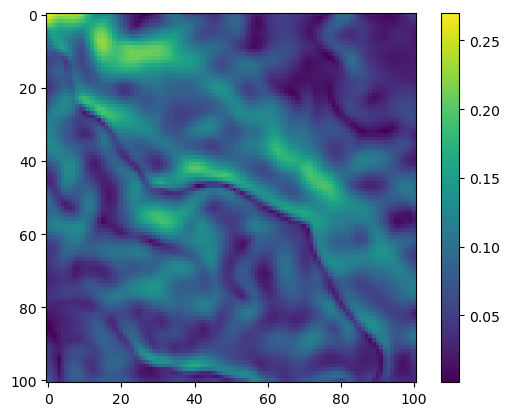

In [17]:
for i in range(0, 1):
    plt.imshow(slope_tens_norm[i])
    plt.colorbar()  
    plt.show()

## Presence records - target of model

In [18]:
# Path to your TIF file
file_path = '../buffalo_local_layers_id/buffalo_2005_pres_cent101x101_lag_1hr_n10297.tif'
# with lag
# file_path = '../synthetic_pres_cent100x100_lag_6hr_n10000.tif'

# Using rasterio 
with rasterio.open(file_path) as pres:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    pres_stack = pres.read([i for i in range(1, pres.count + 1)])

print(pres_stack.shape)
print(type(pres_stack))

(10103, 101, 101)
<class 'numpy.ndarray'>


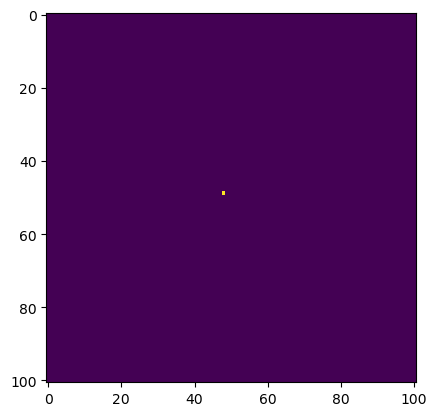

In [19]:
for i in range(0, 1):
    plt.imshow(pres_stack[i])
    plt.show()

In [20]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cpu device


### Combine the spatial layers into channels

In [21]:
# Stack the channels along a new axis; here, 1 is commonly used for channel axis in PyTorch
combined_stack = torch.stack([ndvi_tens_norm, canopy_tens_norm, herby_tens_norm, slope_tens_norm], dim=1)
combined_stack
print(combined_stack.shape)

torch.Size([10103, 4, 101, 101])


## Defining data sets and data loaders

### Creating a dataset class

In [22]:
class buffalo_data(Dataset):

    def __init__(self):
        # data loading
        self.spatial_data_x = combined_stack

        # the scalar data that will be converted to grid data and added to the spatial covariates for CNN components
        self.scalar_to_grid_data = torch.from_numpy(buffalo_df[['hour_t2_sin', 'hour_t2_cos', 'yday_t2_sin', 'yday_t2_cos']].values).float()

        # self.bearing_x = torch.from_numpy(buffalo_df[['bearing']].values).float()
        self.bearing_x = torch.from_numpy(buffalo_df[['bearing_tm1']].values).float()
        
        self.target = torch.tensor(pres_stack)
        
        self.n_samples = self.spatial_data_x.shape[0]

    def __len__(self):
        # len(data)
        return self.n_samples

    def __getitem__(self, index):
        # allows for indexing of the dataset
        return self.spatial_data_x[index], self.scalar_to_grid_data[index], self.bearing_x[index], self.target[index]

In [23]:
# torch.from_numpy(buffalo_df['bearing'].values).float()
torch.from_numpy(buffalo_df['bearing_tm1'].values).float()

tensor([ 0.0000,  2.8025,  2.7810,  ...,  0.2380,  0.8608, -1.5966])

In [24]:
dataset = buffalo_data()
first_data = dataset[:]
# print(first_data)
print(dataset.n_samples)

features1, features2, features3, labels = first_data
print(features1.shape)
print(features2.shape)
print(features3.shape)
print(labels.shape)

# print(features1)
# print(features2)
# print(features3)
# print(labels)

# dataset.shape
# print(dataset[0,:])

10103
torch.Size([10103, 4, 101, 101])
torch.Size([10103, 4])
torch.Size([10103, 1])
torch.Size([10103, 101, 101])


### Split into training, validation and test sets

In [25]:
training_split = 0.8
validation_split = 0.1
test_split = 0.1

dataset_train, dataset_val, dataset_test = torch.utils.data.random_split(dataset, [training_split, validation_split, test_split])
print(len(dataset_train))
print(len(dataset_val))
print(len(dataset_test))

8083
1010
1010


### Create dataloaders

In [26]:
bs = 32 # batch size
dataloader_train = DataLoader(dataset=dataset_train, batch_size=bs, shuffle=True)
dataloader_val = DataLoader(dataset=dataset_val, batch_size=bs, shuffle=True)
dataloader_test = DataLoader(dataset=dataset_test, batch_size=bs, shuffle=True)

In [27]:
# Display image and label.
features1, features2, features3, labels = next(iter(dataloader_train))
print(f"Feature 1 batch shape: {features1.size()}")
print(f"Feature 2 batch shape: {features2.size()}")
print(f"Feature 3 batch shape: {features3.size()}")
print(f"Labels batch shape: {labels.size()}")

Feature 1 batch shape: torch.Size([32, 4, 101, 101])
Feature 2 batch shape: torch.Size([32, 4])
Feature 3 batch shape: torch.Size([32, 1])
Labels batch shape: torch.Size([32, 101, 101])


# Define the model

In [45]:
class Conv2d_block_toFC(nn.Module):
    def __init__(self, params):
        super(Conv2d_block_toFC, self).__init__()
        self.batch_size = params.batch_size
        self.input_channels = params.input_channels
        self.output_channels = params.output_channels
        self.kernel_size = params.kernel_size
        self.stride = params.stride
        self.kernel_size_mp = params.kernel_size_mp
        self.stride_mp = params.stride_mp
        self.padding = params.padding
        self.image_dim = params.image_dim
        self.device = params.device

        self.conv2d = nn.Sequential(
        nn.Conv2d(in_channels=self.input_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        nn.Conv2d(in_channels=self.output_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        nn.Flatten())

    def forward(self, x):
        return self.conv2d(x)
    

class Conv2d_block_spatial(nn.Module):
    def __init__(self, params):
        super(Conv2d_block_spatial, self).__init__()
        self.batch_size = params.batch_size
        self.input_channels = params.input_channels
        self.output_channels = params.output_channels
        self.kernel_size = params.kernel_size
        self.stride = params.stride
        # self.kernel_size_mp = params.kernel_size_mp
        # self.stride_mp = params.stride_mp
        self.padding = params.padding
        self.image_dim = params.image_dim
        self.device = params.device

        self.conv2d = nn.Sequential(
        nn.Conv2d(in_channels=self.input_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.output_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.output_channels, out_channels=1, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        )

    def forward(self, x):
        # print("Shape before squeeze:", self.conv2d(x).shape)
        conv2d_spatial = self.conv2d(x).squeeze(dim = 1)
        # print("Shape before logsumexp:", conv2d_spatial.shape)
        conv2d_spatial = conv2d_spatial - torch.logsumexp(conv2d_spatial, dim = (1, 2), keepdim = True)
        # conv2d_spatial = conv2d_spatial/torch.sum(conv2d_spatial)
        return conv2d_spatial


class FCN_block_all_habitat(nn.Module):
    def __init__(self, params):
        super(FCN_block_all_habitat, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_all = params.dense_dim_in_all
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_all, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.image_dim * self.image_dim)
        )
    
    def forward(self, x):
        return self.ffn(x)


class FCN_block_all_movement(nn.Module):
    def __init__(self, params):
        super(FCN_block_all_movement, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_all = params.dense_dim_in_all
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.num_movement_params = params.num_movement_params
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_all, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.num_movement_params)
        )
    
    def forward(self, x):
        return self.ffn(x)
    
class FCN_block_nonspatial(nn.Module):
    def __init__(self, params):
        super(FCN_block_nonspatial, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_nonspatial = params.dense_dim_in_nonspatial
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_nonspatial, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_out)
        )
    
    def forward(self, x):
        return self.ffn(x)



##################################################
# Mixture of two Gamma and von Mises distributions with the von Mises mu parameters allowed to vary
##################################################


# class Params_to_Grid_Block(nn.Module):
#     def __init__(self, params):
#         super(Params_to_Grid_Block, self).__init__()
#         self.batch_size = params.batch_size
#         self.image_dim = params.image_dim
#         self.pixel_size = params.pixel_size
#         self.center = self.image_dim // 2
#         y, x = np.indices((self.image_dim, self.image_dim))
#         self.distance_layer = torch.from_numpy(np.sqrt((self.pixel_size*(x - self.center))**2 + (self.pixel_size*(y - self.center))**2))
#         # change the centre cell to the average distance from the centre to the edge of the pixel
#         self.distance_layer[self.center, self.center] = 0.56*self.pixel_size # average distance from the centre to the perimeter of the pixel (accounting for longer distances at the corners)
#         self.bearing_layer = torch.from_numpy(np.arctan2(y - self.center, x - self.center))
#         self.device = params.device


#     # Gamma desnities for the mixture distribution
#     def gamma_density(self, x, shape, scale):
#         return -1*torch.lgamma(shape) -shape*torch.log(scale) + (shape - 1)*torch.log(x) - x/scale
    
#     # von Mises densities for the mixture distribution
#     def vonmises_density(self, x, kappa, vm_mu):
#         return kappa*torch.cos(x - vm_mu) - 1*(np.log(2*torch.pi) + torch.log(torch.special.i0(kappa)))
    

#     def forward(self, x, bearing):

#         # parameters of the first mixture distribution
#         gamma_shape1 = torch.exp(x[:, 0]).unsqueeze(0).unsqueeze(0)
#         gamma_shape1 = gamma_shape1.repeat(self.image_dim, self.image_dim, 1)
#         gamma_shape1 = gamma_shape1.permute(2, 0, 1)

#         gamma_scale1 = torch.exp(x[:, 1]).unsqueeze(0).unsqueeze(0)
#         gamma_scale1 = gamma_scale1.repeat(self.image_dim, self.image_dim, 1)
#         gamma_scale1 = gamma_scale1.permute(2, 0, 1)

#         gamma_weight1 = torch.exp(x[:, 2]).unsqueeze(0).unsqueeze(0)
#         gamma_weight1 = gamma_weight1.repeat(self.image_dim, self.image_dim, 1)
#         gamma_weight1 = gamma_weight1.permute(2, 0, 1)

#         # parameters of the second mixture distribution
#         gamma_shape2 = torch.exp(x[:, 3]).unsqueeze(0).unsqueeze(0)
#         gamma_shape2 = gamma_shape2.repeat(self.image_dim, self.image_dim, 1)
#         gamma_shape2 = gamma_shape2.permute(2, 0, 1)

#         gamma_scale2 = torch.exp(x[:, 4]).unsqueeze(0).unsqueeze(0)
#         gamma_scale2 = gamma_scale2.repeat(self.image_dim, self.image_dim, 1)
#         gamma_scale2 = gamma_scale2.permute(2, 0, 1)

#         gamma_weight2 = torch.exp(x[:, 5]).unsqueeze(0).unsqueeze(0)
#         gamma_weight2 = gamma_weight2.repeat(self.image_dim, self.image_dim, 1)
#         gamma_weight2 = gamma_weight2.permute(2, 0, 1)


#         # calculation of Gamma densities
#         gamma_density_layer1 = self.gamma_density(self.distance_layer, gamma_shape1, gamma_scale1)
#         gamma_density_layer2 = self.gamma_density(self.distance_layer, gamma_shape2, gamma_scale2)

#         # normalise the gamma weights so they sum to 1
#         gamma_weight1 = gamma_weight1/(gamma_weight1 + gamma_weight2)
#         # print('Gamma weight1 shape ', gamma_weight1.shape)
#         gamma_weight2 = gamma_weight2/(gamma_weight1 + gamma_weight2)
#         # print('Gamma weight2 shape ', gamma_weight2.shape)

#         # combining both densities to create a mixture distribution using logsumexp
#         logsumexp_gamma_corr = torch.max(gamma_density_layer1, gamma_density_layer2)
#         gamma_density_layer = logsumexp_gamma_corr + torch.log(gamma_weight1 * torch.exp(gamma_density_layer1 - logsumexp_gamma_corr) + gamma_weight2 * torch.exp(gamma_density_layer2 - logsumexp_gamma_corr))
#         # print(torch.sum(gamma_density_layer))
#         # print(torch.sum(torch.exp(gamma_density_layer)))

#         # normalise the gamma weights so they sum to 1
#         gamma_density_layer = gamma_density_layer - torch.logsumexp(gamma_density_layer, dim = (1, 2), keepdim = True)
#         # print(torch.sum(gamma_density_layer))
#         # print(torch.sum(torch.exp(gamma_density_layer)))


#         ## Von Mises Distributions

#         # calculate the new bearing from the turning angle
#         # takes in the bearing from the previous step and adds the turning angle
#         bearing_new1 = x[:, 6] + bearing[:, 0]
#         # the new bearing becomes the mean of the von Mises distribution
#         # the estimated parameter [x:, 7] is the turning angle of the next step
#         # which is always in reference to the input bearing
#         vonmises_mu1 = bearing_new1.unsqueeze(0).unsqueeze(0)
#         vonmises_mu1 = vonmises_mu1.repeat(self.image_dim, self.image_dim, 1)
#         vonmises_mu1 = vonmises_mu1.permute(2, 0, 1)

#         # parameters of the first von Mises distribution
#         vonmises_kappa1 = torch.exp(x[:, 7]).unsqueeze(0).unsqueeze(0)
#         vonmises_kappa1 = vonmises_kappa1.repeat(self.image_dim, self.image_dim, 1)
#         vonmises_kappa1 = vonmises_kappa1.permute(2, 0, 1)

#         vonmises_weight1 = torch.exp(x[:, 8]).unsqueeze(0).unsqueeze(0)
#         vonmises_weight1 = vonmises_weight1.repeat(self.image_dim, self.image_dim, 1)
#         vonmises_weight1 = vonmises_weight1.permute(2, 0, 1)

#         # vm_mu and weight for the second von Mises distribution
#         bearing_new2 = x[:, 9] + bearing[:, 0]
#         vonmises_mu2 = bearing_new2.unsqueeze(0).unsqueeze(0)
#         vonmises_mu2 = vonmises_mu2.repeat(self.image_dim, self.image_dim, 1)
#         vonmises_mu2 = vonmises_mu2.permute(2, 0, 1)

#         # parameters of the second von Mises distribution
#         vonmises_kappa2 = torch.exp(x[:, 10]).unsqueeze(0).unsqueeze(0)
#         vonmises_kappa2 = vonmises_kappa2.repeat(self.image_dim, self.image_dim, 1)
#         vonmises_kappa2 = vonmises_kappa2.permute(2, 0, 1)

#         vonmises_weight2 = torch.exp(x[:, 11]).unsqueeze(0).unsqueeze(0)
#         vonmises_weight2 = vonmises_weight2.repeat(self.image_dim, self.image_dim, 1)
#         vonmises_weight2 = vonmises_weight2.permute(2, 0, 1)
        

#         # calculation of von Mises densities
#         vonmises_density_layer1 = self.vonmises_density(self.bearing_layer, vonmises_kappa1, vonmises_mu1)
#         vonmises_density_layer2 = self.vonmises_density(self.bearing_layer, vonmises_kappa2, vonmises_mu2)

#         # normalise the von Mises weights so they sum to 1
#         vonmises_weight1 = vonmises_weight1/(vonmises_weight1 + vonmises_weight2)
#         vonmises_weight2 = vonmises_weight2/(vonmises_weight1 + vonmises_weight2)

#         # combining both densities to create a mixture distribution using the logsumexp trick
#         logsumexp_vm_corr = torch.max(vonmises_density_layer1, vonmises_density_layer2)
#         vonmises_density_layer = logsumexp_vm_corr + torch.log(vonmises_weight1 * torch.exp(vonmises_density_layer1 - logsumexp_vm_corr) + vonmises_weight2 * torch.exp(vonmises_density_layer2 - logsumexp_vm_corr))
#         # print(torch.sum(vonmises_density_layer))
#         # print(torch.sum(torch.exp(vonmises_density_layer)))
#         vonmises_density_layer = vonmises_density_layer - torch.logsumexp(vonmises_density_layer, dim = (1, 2), keepdim = True)
#         # normalise so the densities sum to 1 when exponentiated
#         # print(torch.sum(vonmises_density_layer))
#         # print(torch.sum(torch.exp(vonmises_density_layer)))

#         # combining the two distributions
#         movement_grid = gamma_density_layer + vonmises_density_layer # Gamma and von Mises densities are on the log-scale
#         # print('Movement grid ', torch.sum(movement_grid))
#         # print(torch.sum(torch.exp(movement_grid)))
#         movement_grid = movement_grid - torch.logsumexp(movement_grid, dim = (1, 2), keepdim = True)
#         # print('Movement grid norm ', torch.sum(movement_grid))
#         # print(torch.sum(torch.exp(movement_grid)))

#         return movement_grid
    
    
##################################################
# Mixture of two Gamma and von Mises distributions with the von Mises mu parameters fixed to 0 and -pi
##################################################

class Params_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Params_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.pixel_size = params.pixel_size
        self.center = self.image_dim // 2
        y, x = np.indices((self.image_dim, self.image_dim))
        self.distance_layer = torch.from_numpy(np.sqrt((self.pixel_size*(x - self.center))**2 + (self.pixel_size*(y - self.center))**2))
        # change the centre cell to the average distance from the centre to the edge of the pixel
        self.distance_layer[self.center, self.center] = 0.56*self.pixel_size # average distance from the centre to the perimeter of the pixel (accounting for longer distances at the corners)
        # self.bearing_layer = torch.from_numpy(np.arctan2(y - self.center, x - self.center))
        self.bearing_layer = torch.from_numpy(np.arctan2(self.center - y, x - self.center))
        self.device = params.device


    # Gamma desnities for the mixture distribution
    def gamma_density(self, x, shape, scale):
        # Ensure all tensors are on the same device as x
        shape = shape.to(x.device)
        scale = scale.to(x.device)
        return -1*torch.lgamma(shape) -shape*torch.log(scale) + (shape - 1)*torch.log(x) - x/scale

    # von Mises densities for the mixture distribution
    def vonmises_density(self, x, kappa, vm_mu):
        # Ensure all tensors are on the same device as x
        kappa = kappa.to(x.device)
        vm_mu = vm_mu.to(x.device)
        return kappa*torch.cos(x - vm_mu) - 1*(np.log(2*torch.pi) + torch.log(torch.special.i0(kappa)))
    

    def forward(self, x, bearing):

        # parameters of the first mixture distribution
        gamma_shape1 = torch.exp(x[:, 0]).unsqueeze(0).unsqueeze(0)
        gamma_shape1 = gamma_shape1.repeat(self.image_dim, self.image_dim, 1)
        gamma_shape1 = gamma_shape1.permute(2, 0, 1)

        gamma_scale1 = torch.exp(x[:, 1]).unsqueeze(0).unsqueeze(0)
        gamma_scale1 = gamma_scale1.repeat(self.image_dim, self.image_dim, 1)
        gamma_scale1 = gamma_scale1.permute(2, 0, 1)

        gamma_weight1 = torch.exp(x[:, 2]).unsqueeze(0).unsqueeze(0)
        gamma_weight1 = gamma_weight1.repeat(self.image_dim, self.image_dim, 1)
        gamma_weight1 = gamma_weight1.permute(2, 0, 1)

        # parameters of the second mixture distribution
        gamma_shape2 = torch.exp(x[:, 3]).unsqueeze(0).unsqueeze(0)
        gamma_shape2 = gamma_shape2.repeat(self.image_dim, self.image_dim, 1)
        gamma_shape2 = gamma_shape2.permute(2, 0, 1)

        gamma_scale2 = torch.exp(x[:, 4]).unsqueeze(0).unsqueeze(0)
        gamma_scale2 = gamma_scale2 * 500 ### to transform the scale parameter to be near 1
        gamma_scale2 = gamma_scale2.repeat(self.image_dim, self.image_dim, 1)
        gamma_scale2 = gamma_scale2.permute(2, 0, 1)

        gamma_weight2 = torch.exp(x[:, 5]).unsqueeze(0).unsqueeze(0)
        gamma_weight2 = gamma_weight2.repeat(self.image_dim, self.image_dim, 1)
        gamma_weight2 = gamma_weight2.permute(2, 0, 1)

        # Apply softmax to the weights
        gamma_weights = torch.stack([gamma_weight1, gamma_weight2], dim=0)
        gamma_weights = torch.nn.functional.softmax(gamma_weights, dim=0)
        gamma_weight1 = gamma_weights[0]
        gamma_weight2 = gamma_weights[1]

        # calculation of Gamma densities
        gamma_density_layer1 = self.gamma_density(self.distance_layer, gamma_shape1, gamma_scale1).to(device)
        gamma_density_layer2 = self.gamma_density(self.distance_layer, gamma_shape2, gamma_scale2).to(device)

        # combining both densities to create a mixture distribution using logsumexp
        logsumexp_gamma_corr = torch.max(gamma_density_layer1, gamma_density_layer2)
        gamma_density_layer = logsumexp_gamma_corr + torch.log(gamma_weight1 * torch.exp(gamma_density_layer1 - logsumexp_gamma_corr) + gamma_weight2 * torch.exp(gamma_density_layer2 - logsumexp_gamma_corr))
        # print(torch.sum(gamma_density_layer))
        # print(torch.sum(torch.exp(gamma_density_layer)))

        # normalise the gamma weights so they sum to 1
        # gamma_density_layer = gamma_density_layer - torch.logsumexp(gamma_density_layer, dim = (1, 2), keepdim = True)
        # print(torch.sum(gamma_density_layer))
        # print(torch.sum(torch.exp(gamma_density_layer)))


        ## Von Mises Distributions

        # calculate the new bearing from the turning angle
        # takes in the bearing from the previous step and adds the turning angle
        bearing_new1 = x[:, 6] + bearing[:, 0]
        # bearing_new1 = 0.0 + bearing[:, 0]

        # print('Bearing.shape ', bearing.shape)
        # print('Bearing[:, 0].shape ', bearing[:, 0].shape)
        # print('Bearing[:, 0] ', bearing[:, 0])
        # the new bearing becomes the mean of the von Mises distribution
        # the estimated parameter [x:, 7] is the turning angle of the next step
        # which is always in reference to the input bearing
        vonmises_mu1 = bearing_new1.unsqueeze(0).unsqueeze(0)
        vonmises_mu1 = vonmises_mu1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_mu1 = vonmises_mu1.permute(2, 0, 1)

        # parameters of the first von Mises distribution
        vonmises_kappa1 = torch.exp(x[:, 7]).unsqueeze(0).unsqueeze(0)
        vonmises_kappa1 = vonmises_kappa1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_kappa1 = vonmises_kappa1.permute(2, 0, 1)

        vonmises_weight1 = torch.exp(x[:, 8]).unsqueeze(0).unsqueeze(0)
        vonmises_weight1 = vonmises_weight1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_weight1 = vonmises_weight1.permute(2, 0, 1)

        # vm_mu and weight for the second von Mises distribution
        bearing_new2 = x[:, 9] + bearing[:, 0]
        # bearing_new2 = torch.pi + bearing[:, 0]

        vonmises_mu2 = bearing_new2.unsqueeze(0).unsqueeze(0)
        vonmises_mu2 = vonmises_mu2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_mu2 = vonmises_mu2.permute(2, 0, 1)

        # parameters of the second von Mises distribution
        vonmises_kappa2 = torch.exp(x[:, 10]).unsqueeze(0).unsqueeze(0)
        vonmises_kappa2 = vonmises_kappa2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_kappa2 = vonmises_kappa2.permute(2, 0, 1)

        vonmises_weight2 = torch.exp(x[:, 11]).unsqueeze(0).unsqueeze(0)
        vonmises_weight2 = vonmises_weight2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_weight2 = vonmises_weight2.permute(2, 0, 1)

        # Apply softmax to the weights
        vonmises_weights = torch.stack([vonmises_weight1, vonmises_weight2], dim=0)
        vonmises_weights = torch.nn.functional.softmax(vonmises_weights, dim=0)
        vonmises_weight1 = vonmises_weights[0]
        vonmises_weight2 = vonmises_weights[1]

        # calculation of von Mises densities
        vonmises_density_layer1 = self.vonmises_density(self.bearing_layer, vonmises_kappa1, vonmises_mu1).to(device)
        vonmises_density_layer2 = self.vonmises_density(self.bearing_layer, vonmises_kappa2, vonmises_mu2).to(device)

        # combining both densities to create a mixture distribution using the logsumexp trick
        logsumexp_vm_corr = torch.max(vonmises_density_layer1, vonmises_density_layer2)
        vonmises_density_layer = logsumexp_vm_corr + torch.log(vonmises_weight1 * torch.exp(vonmises_density_layer1 - logsumexp_vm_corr) + vonmises_weight2 * torch.exp(vonmises_density_layer2 - logsumexp_vm_corr))
        # print(torch.sum(vonmises_density_layer))
        # print(torch.sum(torch.exp(vonmises_density_layer)))

        # normalise so the densities sum to 1 when exponentiated
        # vonmises_density_layer = vonmises_density_layer - torch.logsumexp(vonmises_density_layer, dim = (1, 2), keepdim = True)
        # print(torch.sum(vonmises_density_layer))
        # print(torch.sum(torch.exp(vonmises_density_layer)))

        # combining the two distributions
        movement_grid = gamma_density_layer + vonmises_density_layer # Gamma and von Mises densities are on the log-scale
        # print('Movement grid ', torch.sum(movement_grid))
        # print(torch.sum(torch.exp(movement_grid)))
        movement_grid = movement_grid - torch.logsumexp(movement_grid, dim = (1, 2), keepdim = True)
        # print('Movement grid norm ', torch.sum(movement_grid))
        # print(torch.sum(torch.exp(movement_grid)))

        return movement_grid
    

class Scalar_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Scalar_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.device = params.device
    
    def forward(self, x):
        num_scalars = x.shape[1]
        scalar_map = x.view(x.shape[0], num_scalars, 1, 1).expand(x.shape[0], num_scalars, self.image_dim, self.image_dim)
        return scalar_map


class Vector_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Vector_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.device = params.device
    
    def forward(self, x):
        x_unnorm = x.reshape(x.shape[0], self.image_dim, self.image_dim)
        x = x_unnorm - torch.logsumexp(x_unnorm, dim = (1, 2), keepdim = True)
        return x
    
        # x = x_unnorm/torch.sum(x_unnorm)
        # return x


class ConvJointModel(nn.Module):
    def __init__(self, params):
        super(ConvJointModel, self).__init__()
        # self.conv_habitat = Conv2d_block(params)
        # self.fcn_habitat_all = FCN_block_all_habitat(params)
        # self.fcn_habitat_nonspatial = FCN_block_nonspatial(params)
        # self.habitat_grid_output = Vector_to_Grid_Block(params)

        self.scalar_grid_output = Scalar_to_Grid_Block(params)
        self.conv_habitat = Conv2d_block_spatial(params)

        self.conv_movement = Conv2d_block_toFC(params)
        self.fcn_movement_all = FCN_block_all_movement(params)
        self.fcn_movement_nonspatial = FCN_block_nonspatial(params)
        self.movement_grid_output = Params_to_Grid_Block(params)
        self.device = params.device

    def forward(self, x):
        spatial_data_x = x[0]
        scalars_to_grid = x[1]
        # additional_data_x = x[2]
        bearing_x = x[2]

        # conv_habitat = self.conv_habitat(spatial_data_x)
        # covariates_habitat = self.fcn_habitat_nonspatial(additional_data_x)
        # all_predictors_habitat = torch.cat([conv_habitat, covariates_habitat], dim = 1)
        # # print(f"Shape after concatenation: {all_predictors_habitat.shape}")  # Debugging print
        # output_habitat = self.fcn_habitat_all(all_predictors_habitat)
        # output_habitat = self.habitat_grid_output(output_habitat)

        # SCALAR GRIDS
        scalar_grids = self.scalar_grid_output(scalars_to_grid)
        all_spatial = torch.cat([spatial_data_x, scalar_grids], dim = 1)
        # print(f"Shape after scalar grid: {all_spatial.shape}")  # Debugging print


        # HABITAT SELECTION
        output_habitat = self.conv_habitat(all_spatial)
        # print(f"Shape after CNN habitat: {output_habitat.shape}")  # Debugging print


        # MOVEMENT
        conv_movement = self.conv_movement(all_spatial)
        # print(f"Shape after CNN to FC movement: {conv_movement.shape}")  # Debugging print

        # covariates_movement = self.fcn_movement_nonspatial(additional_data_x)
        # print(f"Shape after fcn_movement_nonspatial: {covariates_movement.shape}")  # Debugging print

        # all_predictors_movement = torch.cat([conv_movement, covariates_movement], dim = 1)
        # print(f"Shape after torch.cat([conv_movement, covariates_movement], dim = 1): {all_predictors_movement.shape}")  # Debugging print

        output_movement = self.fcn_movement_all(conv_movement)
        # print(f"Shape after fcn_movement_all: {output_movement.shape}")  # Debugging print
        output_movement = self.movement_grid_output(output_movement, bearing_x)
        # print(f"Shape after CNN movement: {output_movement.shape}")  # Debugging print

        # combine the habitat and movement predictions
        output = torch.stack((output_habitat, output_movement), dim = -1)
        return output
    

class ModelParams():
    def __init__(self, dict_params):
        self.batch_size = dict_params["batch_size"]
        self.image_dim = dict_params["image_dim"]
        self.pixel_size = dict_params["pixel_size"]
        self.batch_size = dict_params["batch_size"]
        self.dim_in_nonspatial_to_grid = dict_params["dim_in_nonspatial_to_grid"]
        self.dense_dim_in_nonspatial = dict_params["dense_dim_in_nonspatial"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.dense_dim_in_all = dict_params["dense_dim_in_all"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.input_channels = dict_params["input_channels"]
        self.output_channels = dict_params["output_channels"]
        self.kernel_size = dict_params["kernel_size"]
        self.stride = dict_params["stride"]
        self.kernel_size_mp = dict_params["kernel_size_mp"]
        self.stride_mp = dict_params["stride_mp"]
        self.padding = dict_params["padding"]
        self.image_dim = dict_params["image_dim"]
        self.num_movement_params = dict_params["num_movement_params"]
        self.dropout = dict_params["dropout"]
        self.device = dict_params["device"]


## Instantiate the model

In [46]:
params_dict = {"batch_size": 32,
               "image_dim": 101, #number of pixels along the edge of each local patch/image
               "pixel_size": 25, #number of metres along the edge of a pixel
               "dim_in_nonspatial_to_grid": 4, #the number of scalar predictors that are converted to a grid and appended to the spatial features
               "dense_dim_in_nonspatial": 4, #change this to however many other scalar predictors you have (bearing, velocity etc)
               "dense_dim_hidden": 128, #number of nodes in the hidden layers
               "dense_dim_out": 128, #number of nodes in the output of the fully connected block (FCN)
               "dense_dim_in_all": 2500,# + 128, #number of inputs entering the fully connected block once the nonspatial features have been concatenated to the spatial features
               "input_channels": 4 + 4, #number of spatial layers in each image + number of scalar layers that are converted to a grid
               "output_channels": 4, #number of filters to learn
               "kernel_size": 3, #the size of the 2D moving windows / kernels that are being learned
               "stride": 1, #the stride used when applying the kernel.  This reduces the dimension of the output if set to greater than 1
               "kernel_size_mp": 2, #the size of the kernel that is used in max pooling operations
               "stride_mp": 2, #the stride that is used in max pooling operations
               "padding": 1, #the amount of padding to apply to images prior to applying the 2D convolution
               "num_movement_params": 12, #number of parameters used to parameterise the movement kernel - when vm mu allowed to vary
               # "num_movement_params": 10, #number of parameters used to parameterise the movement kernel - when vm mu fixed
               "dropout": 0.1,
               "device": device
               }

params = ModelParams(params_dict)
model = ConvJointModel(params).to(device)
# print(model)

## Testing the scalar to grid function

torch.Size([32, 4])
tensor([-0.5000, -0.8660, -0.1798, -0.9837])
torch.Size([32, 4, 101, 101])


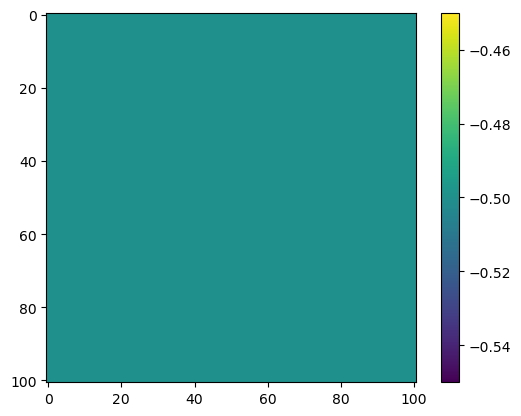

In [47]:
# test_scalars = torch.tensor([[2.0, 1.0]], device=device)
test_data = x1, x2, x3, labels = next(iter(dataloader_test))
test_scalars = x2
print(test_scalars.shape)
print(test_scalars[0,:])

test_block = Scalar_to_Grid_Block(params)
scalar_maps = test_block(test_scalars)
# print(scalar_maps)
print(scalar_maps.shape)

# should show the same value across the grid
plt.imshow(scalar_maps[0, 0])
plt.colorbar()
plt.show()


torch.Size([32, 4, 101, 101])


Text(0.5, 1.0, 'Slope')

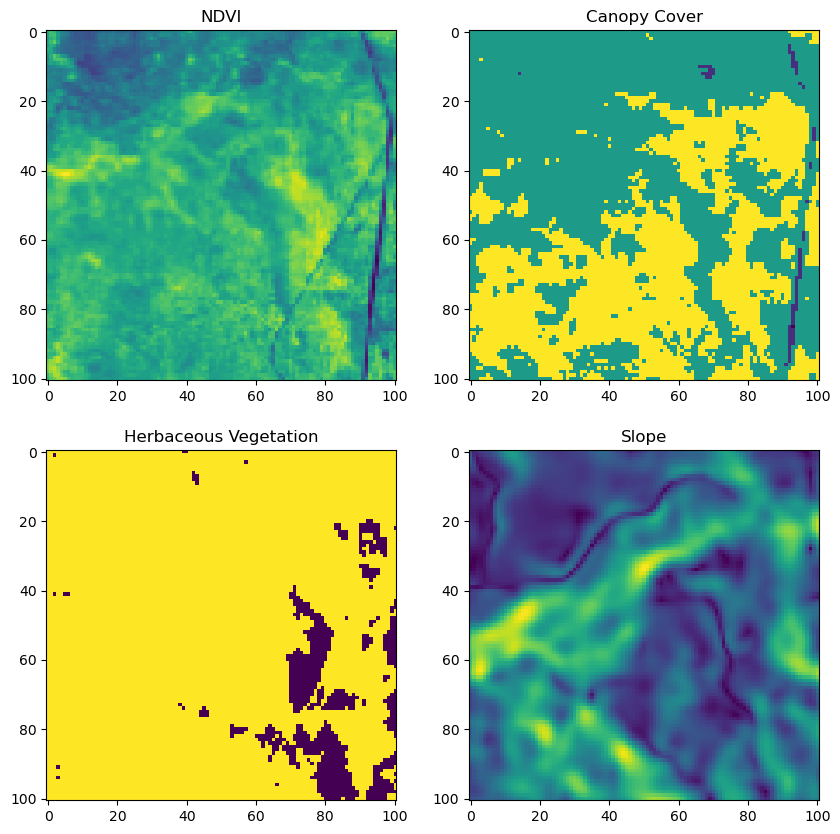

In [48]:
test_covs = x1
print(test_covs.shape)
# plt.imshow(slope_tens_norm[i])

# Plot the subset
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(test_covs.detach().numpy()[0,0,:,:], cmap='viridis')
axs[0, 0].set_title('NDVI')
# axs[0, 0].axis('off')

axs[0, 1].imshow(test_covs.detach().numpy()[0,1,:,:], cmap='viridis')
axs[0, 1].set_title('Canopy Cover')
# axs[0, 1].axis('off')

axs[1, 0].imshow(test_covs.detach().numpy()[0,2,:,:], cmap='viridis')
axs[1, 0].set_title('Herbaceous Vegetation')
# axs[1, 0].axis('off')

axs[1, 1].imshow(test_covs.detach().numpy()[0,3,:,:], cmap='viridis')
axs[1, 1].set_title('Slope')
# axs[1, 1].axis('off')

### Create some random covariates to test the model

tensor([[0.3195, 0.9572, 0.4133, 0.7413]])
tensor([[0.7014]])


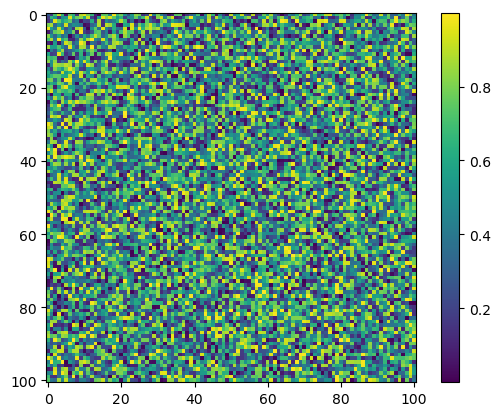

In [49]:
test_batch = 1
x1 = (torch.rand(test_batch, 4, 101, 101, device=device)) #spatial data
x2 = (torch.rand(test_batch, 4, device=device)) #other scalar covariates
x3 = (torch.rand(test_batch, 1, device=device)) # bearing
# x4 = (torch.rand(test_batch, 1, device=device)) #bearing
# y = (torch.rand(1, 1, 101, 101, device=device)) #spatial data
print(x2)
print(x3)
# print(x4)

# plot the results of the movement density as an image
plt.imshow(x1.detach().cpu().numpy()[0, 0, :,:])
plt.colorbar()
plt.show()

# synth_ds = TensorDataset(x1, x2, y)
# synth_dl = DataLoader(synth_ds, batch_size=1, shuffle=True)

torch.Size([1, 101, 101, 2])


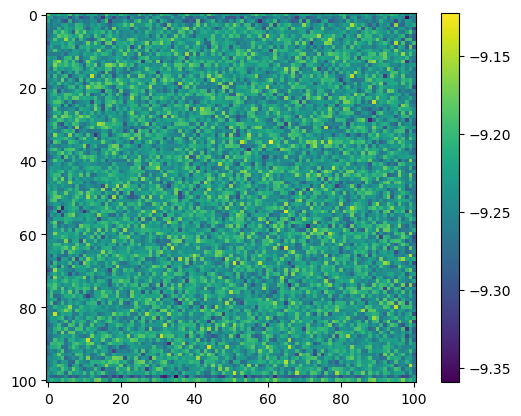

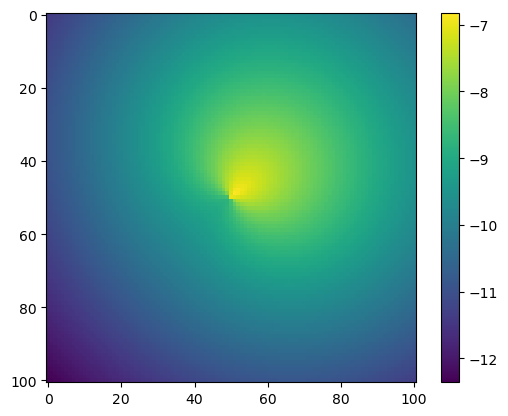

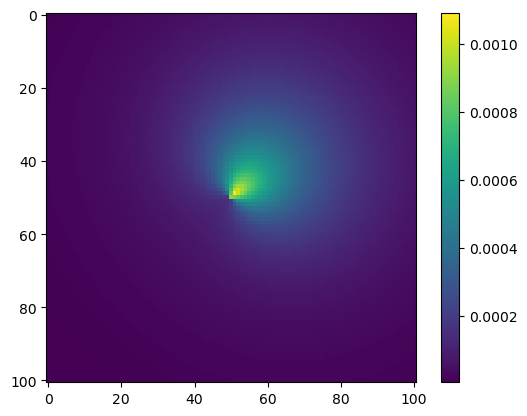

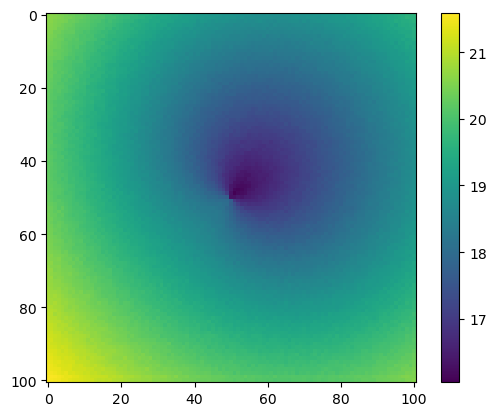

In [50]:
#Test that the model runs
# x1, x2 = synth_ds[0][0], synth_ds[0][1]
test = model((x1, x2, x3))
print(test.shape)
# print(test)

# plot the results of the habitat density as an image
plt.imshow(test.detach().numpy()[0,:,:,0])
plt.colorbar()
plt.show()

# plot the results of the movement density as an image
plt.imshow(test.detach().numpy()[0,:,:,1])
plt.colorbar()
plt.show()

# plot the results of the exp movement density as an image
plt.imshow(np.exp(test.detach().numpy()[0,:,:,1]))
plt.colorbar()
plt.show()

test_cat = -1 * (test[:, :, :, 0] + test[:, :, :, 1])
# test_cat = torch.log(test[:, :, :, 0]*test[:, :, :, 1])
# test_cat = -1 * test[:, :, :, 0] * torch.exp(test[:, :, :, 1])

plt.imshow(test_cat.detach().numpy()[0,:,:])
plt.colorbar()
plt.show()

### Testing the movement parameter block with known Gamma and von Mises parameters

In [34]:
y, x = np.indices((101, 101))
# print(x,y)
center = 50

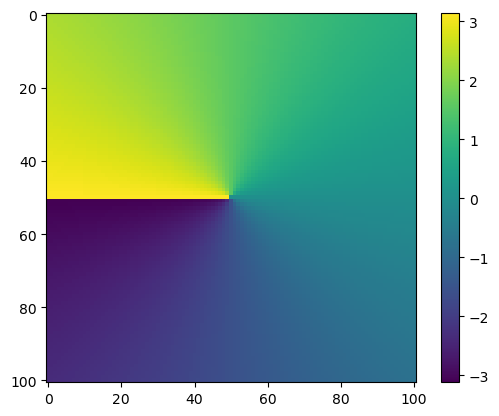

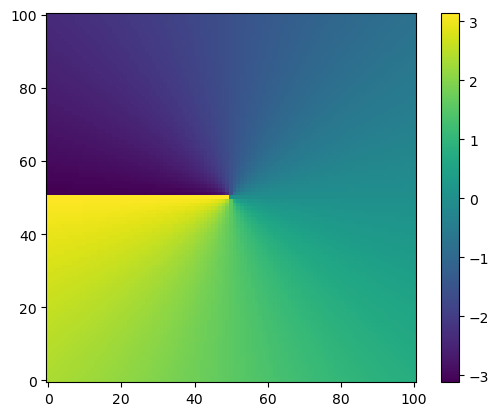

In [35]:
# bearing_layer = torch.from_numpy(np.arctan2(y - center, x - center))
bearing_layer = torch.from_numpy(np.arctan2(center - y, x - center))
# print(bearing_layer)
# print(bearing_layer.shape)
# plot the layer
plt.imshow(bearing_layer)
plt.colorbar()
plt.show()
plt.imshow(bearing_layer, origin='lower')
plt.colorbar()
plt.show()

tensor([[[-14.2022, -14.1165, -14.0315,  ..., -13.4452, -13.5269, -13.6095],
         [-14.1227, -14.0363, -13.9506,  ..., -13.3610, -13.4436, -13.5271],
         [-14.0441, -13.9569, -13.8704,  ..., -13.2778, -13.3613, -13.4457],
         ...,
         [-13.9752, -13.8909, -13.8074,  ..., -13.8791, -13.9595, -14.0407],
         [-14.0567, -13.9733, -13.8907,  ..., -13.9654, -14.0450, -14.1254],
         [-14.1392, -14.0566, -13.9749,  ..., -14.0524, -14.1312, -14.2109]]],
       dtype=torch.float64)
torch.Size([1, 101, 101])


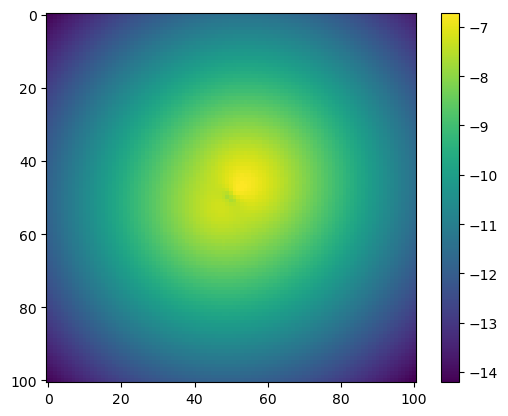

In [36]:
test_bearing = torch.tensor([[0.8]], device=device)

test_block = Params_to_Grid_Block(params)
# movement_density = test_block(torch.rand(1, 4, device=device))
# provide a tensor of shape (batch_size, 4) where the 4 columns are the parameters of the gamma and von mises distributions
# providing values in log space as the values are exponentiated in the forward pass
movement_density = test_block(torch.tensor([[np.log(1.5), np.log(200), np.log(0.25), # gamma 1 - shape, scale and weight
                                             np.log(2.5), np.log(300), np.log(0.75), # gamma 2 - shape, scale and weight
                                             0, np.log(1.5), np.log(0.75),
                                             0, np.log(2.5), np.log(0.25)]], device=device), test_bearing)
# providing values as the model sees them
# movement_density = test_block(torch.tensor([[-.5, -.5, -.5, -.5]], device=device))
print(movement_density)
print(movement_density.shape)

# plot the results of the movement density as an image
plt.imshow(movement_density[0])
plt.colorbar()
plt.show()

## Loss function and optimizer

In [51]:
# Custom loss function to work with the two heatmaps that the model outputs

class negativeLogLikeLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(negativeLogLikeLoss, self).__init__()
        assert reduction in ['mean', 'sum', 'none'], "reduction should be 'mean', 'sum', or 'none'"
        self.reduction = reduction  # Assign reduction to self.reduction
    
    def forward(self, predict, target):
        predict_prod = predict[:, :, :, 0] + predict[:, :, :, 1]          # elementwise summation of the two heatmaps - for log-densities
        # predict_prod = predict[:, :, :, 0]*predict[:, :, :, 1]          # elementwise product of the two heatmaps
        # predict_prod = predict_prod/torch.sum(predict_prod)             # normalise the product of the two heatmaps
        # negLogLike = -1*(predict_prod * target)
        
        # Check for NaNs in the product
        if torch.isnan(predict_prod).any():
            print("NaNs detected in predict_prod")
            print("predict_prod:", predict_prod)
            raise ValueError("NaNs detected in predict_prod")
        
        # predict_prod = predict_prod / torch.sum(predict_prod)  # normalise the product of the two heatmaps
        
        # Check for NaNs after normalization
        # if torch.isnan(predict_prod).any():
        #     print("NaNs detected after normalization")
        #     print("predict_prod:", predict_prod)
        #     raise ValueError("NaNs detected after normalization")
        
        negLogLike = -1 * (predict_prod * target)
        # negLogLike = -1 * torch.log(predict_prod * target)
        
        # Check for NaNs in the negative log likelihood
        if torch.isnan(negLogLike).any():
            print("NaNs detected in negLogLike")
            print("negLogLike:", negLogLike)
            raise ValueError("NaNs detected in negLogLike")

        if self.reduction == 'mean':
            return torch.mean(negLogLike)
        elif self.reduction == 'sum':
            return torch.sum(negLogLike)
        elif self.reduction == 'none':
            return negLogLike
        return negLogLike

### Early stopping code

In [52]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    
    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Instantiate the model

In [53]:
params = ModelParams(params_dict)
model = ConvJointModel(params).to(device)
# print(model)

# # save the model structure
# torch.save(model, 'CNN_model_global.pth')

learning_rate = 1e-4 
loss_fn = negativeLogLikeLoss(reduction='mean')

# path to save the model weights
path_save_weights = 'model_checkpoints/checkpoint_CNN_global_buffalo2005_TAmix_bearing-rev_adj_hab-covs_grid-only_20240913.pt'

optimiser = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', factor=0.1, patience=3)
early_stopping = EarlyStopping(patience=10, verbose=True, path = path_save_weights) # , delta=early_stopping_delta

Text(0.5, 1.0, 'Slope')

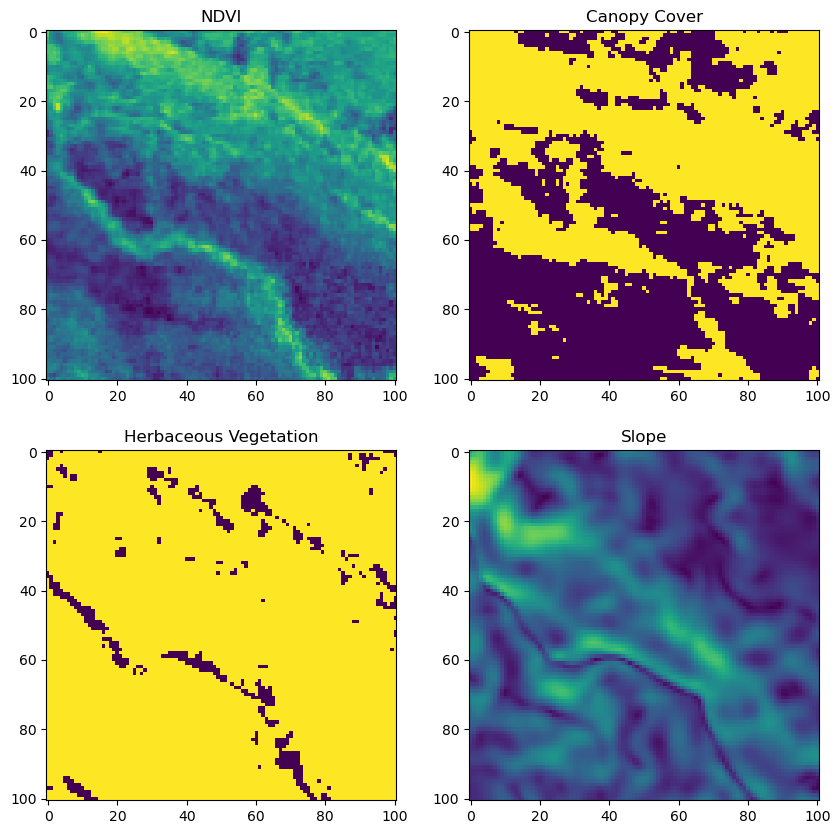

In [54]:
# 1. Set the model in evaluation mode
model.eval()

test_data = x1_plot, x2_plot, x3_plot, labels = next(iter(dataloader_test))
test_covs = x1_plot

# Plot the subset
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(test_covs.detach().numpy()[0,0,:,:], cmap='viridis')
axs[0, 0].set_title('NDVI')
# axs[0, 0].axis('off')

axs[0, 1].imshow(test_covs.detach().numpy()[0,1,:,:], cmap='viridis')
axs[0, 1].set_title('Canopy Cover')
# axs[0, 1].axis('off')

axs[1, 0].imshow(test_covs.detach().numpy()[0,2,:,:], cmap='viridis')
axs[1, 0].set_title('Herbaceous Vegetation')
# axs[1, 0].axis('off')

axs[1, 1].imshow(test_covs.detach().numpy()[0,3,:,:], cmap='viridis')
axs[1, 1].set_title('Slope')
# axs[1, 1].axis('off')


torch.Size([1, 101, 101, 2])


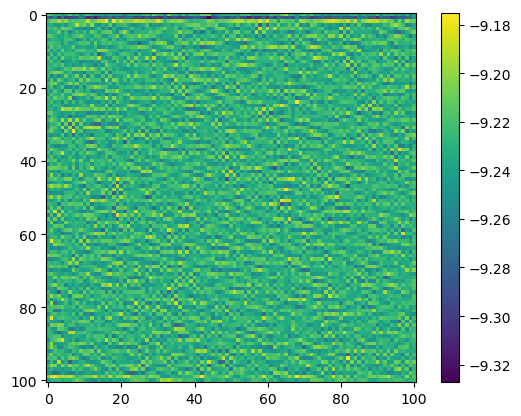

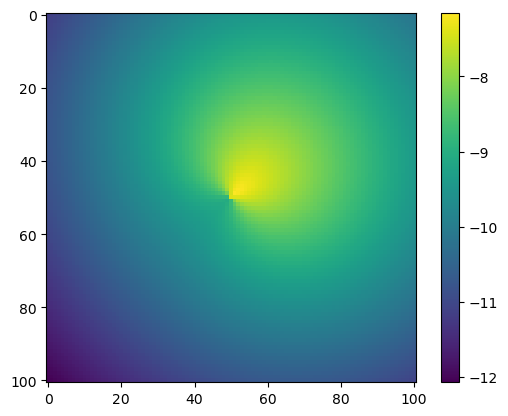

1.0000000000000002


In [55]:
#Test that the model runs
# x1, x2 = synth_ds[0][0], synth_ds[0][1]
test = model((x1, x2, x3))
print(test.shape)
# print(test)

# # plot the results of the habitat density as an image
plt.imshow(test.detach().numpy()[0,:,:,0])
plt.colorbar()
plt.show()

# # plot the results of the movement density as an image
plt.imshow(test.detach().numpy()[0,:,:,1])
plt.colorbar()
plt.show()

print(np.sum(np.exp(test.detach().numpy()[0,:,:,1])))

# test_cat = test[:, :, :, 0]*test[:, :, :, 1] 
# test_cat = test_cat/torch.sum(test_cat) 
# print(test_cat.shape)

# test_cat = -1 * torch.log(test[:, :, :, 0]*test[:, :, :, 1] )
# print(test_cat.shape)

# plt.imshow(test_cat.detach().numpy()[0,:,:])
# plt.colorbar()
# plt.show()

## Training loop

In [56]:
def train_loop(dataloader_train, dataloader_val, model, loss_fn, optimiser, scheduler):
    size = len(dataloader_train.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()

    epoch_loss = 0.0
    # val_loss = 0.0
    # num_batches = len(dataloader_test)

    for batch, (x1, x2, x3, y) in enumerate(dataloader_train):
        
        # calculate the loss
        loss = loss_fn(model((x1, x2, x3)), y)
        epoch_loss += loss

        # for plotting the training progression
        test_plot = model((x1_plot, x2_plot, x3_plot))

        # Get today's date
        today_date = datetime.today().strftime('%Y-%m-%d')

        ## Habitat probability surface
        # Save the figure
        filename_hab = f"outputs/dl_prob_maps/hab_log_prob_norm5_{today_date}_{batch}.png"
        plt.figure()  # Create a new figure
        plt.imshow(test_plot.detach().numpy()[0,:,:,0])
        plt.colorbar()
        plt.draw()  # Ensure the plot is rendered
        plt.savefig(filename_hab, dpi=300)
        # plt.show()
        plt.close()  # Close the figure to free memory

        ## Habitat probability surface
        # Save the figure
        filename_hab = f"outputs/dl_prob_maps/move_log_prob_norm5_{today_date}_{batch}.png"
        plt.figure()  # Create a new figure
        plt.imshow(test_plot.detach().numpy()[0,:,:,1])
        plt.colorbar()
        plt.draw()  # Ensure the plot is rendered
        plt.savefig(filename_hab, dpi=300)
        # plt.show()
        plt.close()  # Close the figure to free memory

        # Backpropagation
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()

        if batch % 5 == 0:
            loss, current = loss.item(), batch * bs + len(x1)
            print(f"loss: {loss:>15f}  [{current:>5d}/{size:>5d}]")

    # # Model validation to assess the learning rate
    # # Set the model to evaluation mode for the validation dataset
    # model.eval()
    # with torch.no_grad():
    #     for x1, x2, y in dataloader_val:
    #         val_loss += loss_fn(model((x1, x2)), y) 
         
    # scheduler.step(val_loss)

    # val_loss /= num_batches
    # print(f"\nAvg validation loss: {val_loss:>15f}")
    # print(f"Learning rate: {scheduler.get_last_lr()}")
    # # print(f"Epoch {t+1}, Total loss: {epoch_loss:>15f}")
    # return val_loss


def test_loop(dataloader_test, model, loss_fn):
    # Set the model to evaluation mode
    model.eval()
    size = len(dataloader_test.dataset)
    num_batches = len(dataloader_test)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for x1, x2, x3, y in dataloader_test:
            test_loss += loss_fn(model((x1, x2, x3)), y)

    test_loss /= num_batches
    # correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Avg test loss: {test_loss:>15f} \n")

## Train the model

In [113]:
epochs = 1

for t in range(epochs):

    val_loss = 0.0
    num_batches = len(dataloader_test)

    print(f"Epoch {t+1}\n-------------------------------")
    
    train_loop(dataloader_train, dataloader_val, model, loss_fn, optimiser, scheduler)

    # Model validation to assess the learning rate
    # Set the model to evaluation mode for the validation dataset
    model.eval()
    with torch.no_grad():
        for x1, x2, x3, y in dataloader_val:
            val_loss += loss_fn(model((x1, x2, x3)), y)    
    scheduler.step(val_loss)

    val_loss /= num_batches
    print(f"\nAvg validation loss: {val_loss:>15f}")
    print(f"Learning rate: {scheduler.get_last_lr()}")
    # print(f"Epoch {t+1}, Total loss: {epoch_loss:>15f}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        #load the optimal model weights
        model.load_state_dict(torch.load(path_save_weights))
        test_loop(dataloader_test, model, loss_fn)
        break
    else:
        model.eval()
        print("\n")

    # test_loop(dataloader_test, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss:        0.001496  [   32/ 8083]
loss:        0.001491  [  192/ 8083]
loss:        0.001514  [  352/ 8083]
loss:        0.001436  [  512/ 8083]
loss:        0.001457  [  672/ 8083]
loss:        0.001416  [  832/ 8083]
loss:        0.001380  [  992/ 8083]
loss:        0.001447  [ 1152/ 8083]
loss:        0.001449  [ 1312/ 8083]
loss:        0.001462  [ 1472/ 8083]
loss:        0.001528  [ 1632/ 8083]
loss:        0.001469  [ 1792/ 8083]
loss:        0.001441  [ 1952/ 8083]
loss:        0.001497  [ 2112/ 8083]
loss:        0.001400  [ 2272/ 8083]
loss:        0.001435  [ 2432/ 8083]
loss:        0.001365  [ 2592/ 8083]
loss:        0.001442  [ 2752/ 8083]
loss:        0.001516  [ 2912/ 8083]
loss:        0.001484  [ 3072/ 8083]
loss:        0.001478  [ 3232/ 8083]
loss:        0.001336  [ 3392/ 8083]
loss:        0.001482  [ 3552/ 8083]
loss:        0.001421  [ 3712/ 8083]
loss:        0.001384  [ 3872/ 8083]
loss:        0.001424  [ 4032/ 8083

In [58]:
print(model.state_dict())
model.load_state_dict(torch.load(path_save_weights, map_location=torch.device('cpu')))

OrderedDict({'conv_habitat.conv2d.0.weight': tensor([[[[-0.0373, -0.0141, -0.0743],
          [ 0.0168,  0.0311,  0.0687],
          [ 0.0164,  0.1051,  0.0890]],

         [[ 0.0069, -0.0321, -0.0408],
          [ 0.0057, -0.0615, -0.0216],
          [-0.0309,  0.0748,  0.0158]],

         [[ 0.0723,  0.1306,  0.1565],
          [ 0.0107,  0.0985,  0.2382],
          [ 0.0500,  0.0027,  0.1017]],

         [[ 0.0435,  0.0146,  0.1734],
          [ 0.1436,  0.1442, -0.0352],
          [ 0.0349,  0.1246,  0.1524]],

         [[-0.0758,  0.0406, -0.0247],
          [-0.0321, -0.0397, -0.0230],
          [ 0.0981, -0.0890,  0.0171]],

         [[-0.0333, -0.0527, -0.0383],
          [-0.1004, -0.0297, -0.0704],
          [-0.0546, -0.0140, -0.0995]],

         [[ 0.0751,  0.0522,  0.1220],
          [ 0.0672,  0.1751, -0.0204],
          [ 0.1014,  0.1578,  0.1906]],

         [[-0.0795,  0.0529,  0.0057],
          [ 0.0407,  0.0666,  0.0606],
          [-0.0087, -0.0875, -0.0297]]],


 

C:\Users\for329\AppData\Local\Temp\ipykernel_20548\3376987567.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_save_weights, map_loc

<All keys matched successfully>

In [ ]:
# # Assuming your model class is defined as MyModel
# print(model)

# # Inspect the forward method of the model
# import inspect
# print(inspect.getsource(model.forward))

# # Assuming your model is already defined and instantiated as `model`
# print("Model Structure:")
# print(model)

# print("\nForward Method:")
# print(inspect.getsource(model.forward))

### Save the model architecture as an onnx file to view with Netron

In [111]:
model.eval()

x1, x2, x3, labels = next(iter(dataloader_test))
model_inputs = ((x1, x2, x3))

print(model(model_inputs))

print(x1.shape)
print(x2.shape)
print(x3.shape)

torch.onnx.export(
    model, 
    model_inputs, 
    "buffalo_TAmix_ID.onnx", 
    verbose=True,
    input_names=["x1", "x2", "x3"],  # Matching input names
    output_names=["output"],
    export_params=True,
)

tensor([[[[-15.1327, -13.9619],
          [-13.8152, -13.9030],
          [-13.1933, -13.8448],
          ...,
          [-14.4170, -14.3661],
          [-14.7048, -14.4319],
          [-15.5850, -14.4982]],

         [[-14.0357, -13.8910],
          [-11.7572, -13.8313],
          [-10.5267, -13.7723],
          ...,
          [-12.4126, -14.3011],
          [-12.9317, -14.3676],
          [-14.4168, -14.4347]],

         [[-13.6148, -13.8206],
          [-10.8688, -13.7601],
          [ -9.3006, -13.7004],
          ...,
          [-11.3243, -14.2367],
          [-11.9569, -14.3040],
          [-13.8278, -14.3718]],

         ...,

         [[-14.9960, -13.9596],
          [-13.3792, -13.8973],
          [-12.1313, -13.8355],
          ...,
          [-11.6280, -14.2149],
          [-12.2224, -14.2824],
          [-13.9718, -14.3505]],

         [[-15.5720, -14.0281],
          [-14.2545, -13.9664],
          [-13.0795, -13.9054],
          ...,
          [-12.8741, -14.2792],
      

TypeError: ConvJointModel.forward() takes 2 positional arguments but 4 were given

## View model outputs

### Run model forward

In [696]:
# 1. Set the model in evaluation mode
model.eval()

# Display image and label.
x1, x2, x3, labels = next(iter(dataloader_test))
print(f"Feature x1 batch shape: {x1.size()}")
print(f"Feature x2 batch shape: {x2.size()}")
print(f"Feature x3 batch shape: {x3.size()}")
# print(f"Feature x4 batch shape: {x3.size()}")
print(f"Labels batch shape: {labels.size()}")

print(x2.detach().numpy()[0,:])

# Pull out the scalars
hour_t2_sin = x2.detach().numpy()[0,0]
hour_t2_cos = x2.detach().numpy()[0,1]
yday_t2_sin = x2.detach().numpy()[0,2]
yday_t2_cos = x2.detach().numpy()[0,3]

# # manual hour of the day
# hour_t2 = 7.0
# # print(hour_t2)
# # convert to sine and cosine
# hour_t2_sin = np.sin(2*np.pi*hour_t2/24)
# hour_t2_cos = np.cos(2*np.pi*hour_t2/24)
# print(f'Hour: {hour_t2_sin}, {hour_t2_cos}')

# bearing_sin = x2.detach().numpy()[0,4]
# bearing_cos = x2.detach().numpy()[0,5]
bearing = x3.detach().numpy()[0,0]

def recover_hour(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    hour = (12 * theta) / np.pi % 24
    return hour

hour_t2 = recover_hour(hour_t2_sin, hour_t2_cos)
hour_t2_integer = int(hour_t2)  # Convert to integer
print(f'Hour: {hour_t2_integer}')

def recover_yday(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    yday = (365 * theta) / (2 * np.pi) % 365
    return yday

yday_t2 = recover_yday(yday_t2_sin, yday_t2_cos)
yday_t2_integer = int(yday_t2)  # Convert to integer
print(f'Day of the year: {yday_t2_integer}')

# Convert the list to a NumPy array
x2_array = np.array([[hour_t2_sin, hour_t2_cos, yday_t2_sin, yday_t2_cos]])
# Convert the NumPy array to a PyTorch tensor
x2 = torch.from_numpy(x2_array).float()
# Repeat the x2 tensor along the batch dimension to match the batch size
x2 = x2.repeat(32, 1)

# def recover_bearing(bearing_sin, bearing_cos):
#     # Calculate the angle (bearing) in radians
#     bearing = np.arctan2(bearing_sin, bearing_cos)
#     # Convert bearing from radians to degrees
#     bearing_degrees = np.degrees(bearing) % 360
#     return bearing_degrees

# bearing = recover_bearing(bearing_sin, bearing_cos)
bearing_degrees = np.degrees(bearing) % 360
bearing_degrees = round(bearing_degrees, 1)  # Round to 2 decimal places
bearing_degrees = int(bearing_degrees)  # Convert to integer
print(f'Bearing (radians): {bearing}')
print(f'Bearing (degrees): {bearing_degrees}')
print(loss_fn(model((x1, x2, x3)), labels))

Feature x1 batch shape: torch.Size([32, 4, 101, 101])
Feature x2 batch shape: torch.Size([32, 4])
Feature x3 batch shape: torch.Size([32, 1])
Labels batch shape: torch.Size([32, 101, 101])
[ 0.8660254  -0.5        -0.7961829  -0.60505605]
Hour: 8
Day of the year: 236
Bearing (radians): 2.5297560691833496
Bearing (degrees): 144
tensor(0.0015, dtype=torch.float64, grad_fn=<MeanBackward0>)


The coordinates of the element that is 1 are (row, column): (49, 49)


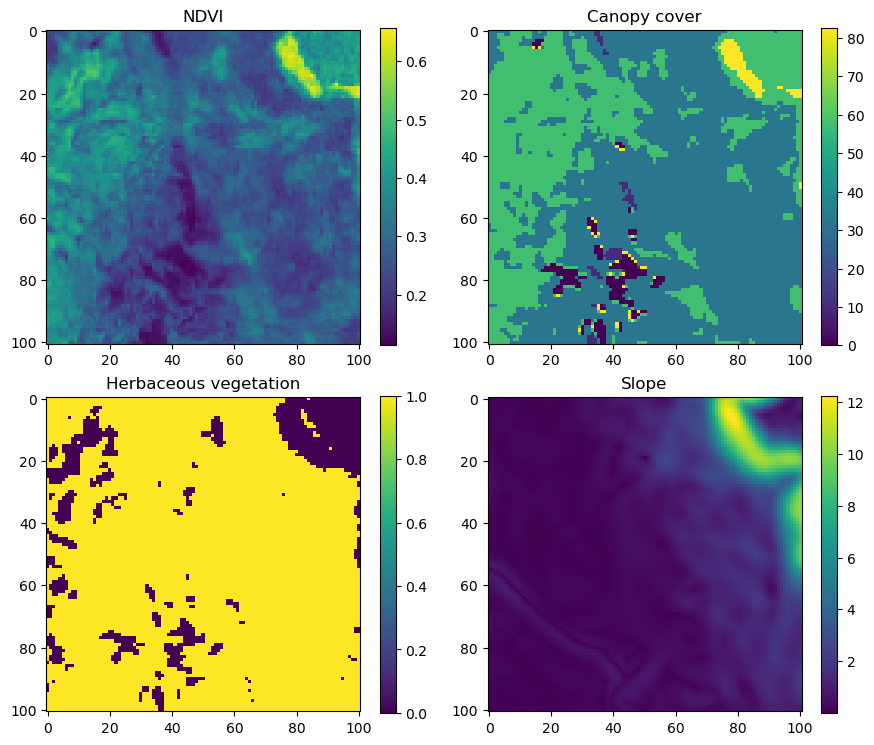

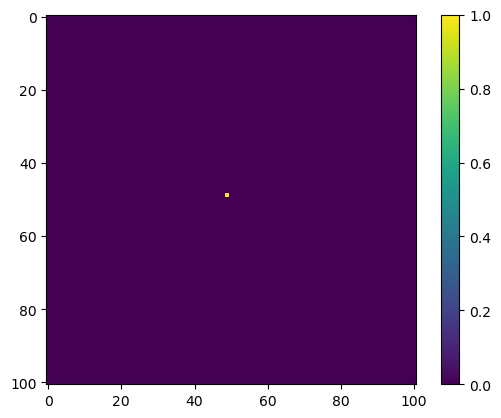

In [697]:
# Plot the covariates
fig, axs = plt.subplots(2, 2, figsize=(9, 7.5))

# Returning data to natural scale
# NDVI
ndvi_norm = x1.detach()[0, 0, :, :]
ndvi_natural = (ndvi_norm * (ndvi_max - ndvi_min)) + ndvi_min
# Canopy cover
canopy_norm = x1.detach()[0, 1, :, :]
canopy_natural = (canopy_norm * (canopy_max - canopy_min)) + canopy_min
# Herbaceous vegetation
herby_norm = x1.detach()[0, 2, :, :]
herby_natural = (herby_norm * (herby_max - herby_min)) + herby_min
# Slope
slope_norm = x1.detach()[0, 3, :, :]
slope_natural = (slope_norm * (slope_max - slope_min)) + slope_min


# Find the coordinates of the element that is 1
target = labels.detach().numpy()[0,:,:]
coordinates = np.where(target == 1)
# Extract the coordinates
row, column = coordinates[0][0], coordinates[1][0]
print(f"The coordinates of the element that is 1 are (row, column): ({row}, {column})")


# Plot NDVI
im1 = axs[0, 0].imshow(ndvi_natural.numpy(), cmap='viridis')
axs[0, 0].set_title('NDVI')
fig.colorbar(im1, ax=axs[0, 0])

# Plot Canopy cover
im2 = axs[0, 1].imshow(canopy_natural.numpy(), cmap='viridis')
axs[0, 1].set_title('Canopy cover')
fig.colorbar(im2, ax=axs[0, 1])

# Plot Herbaceous vegetation
im3 = axs[1, 0].imshow(herby_natural.numpy(), cmap='viridis')
axs[1, 0].set_title('Herbaceous vegetation')
fig.colorbar(im3, ax=axs[1, 0])

# Plot Slope
im4 = axs[1, 1].imshow(slope_natural.numpy(), cmap='viridis')
axs[1, 1].set_title('Slope')
fig.colorbar(im4, ax=axs[1, 1])

filename_covs = f"outputs/step_probs_covs/id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}_covariates.png"
plt.tight_layout()
plt.savefig(filename_covs, dpi=600)
plt.show()
plt.close()  # Close the figure to free memory

# plot the target
plt.imshow(target)
plt.colorbar()
plt.show()


torch.Size([32, 101, 101, 2])


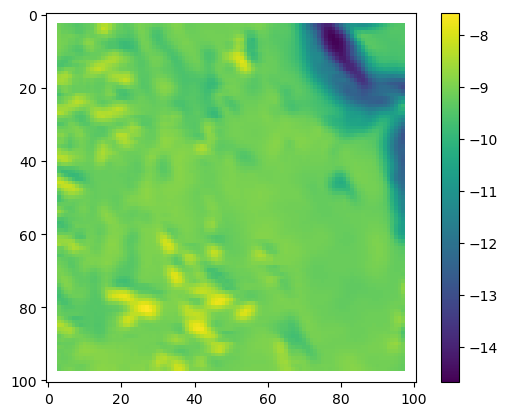

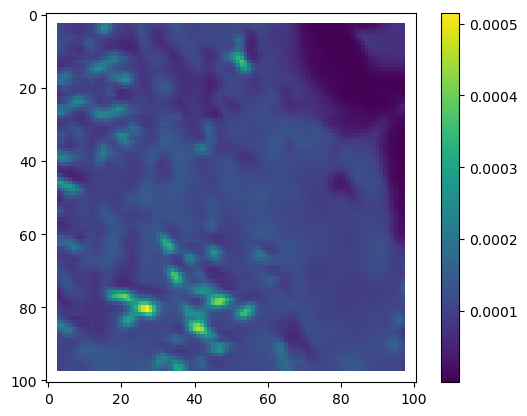

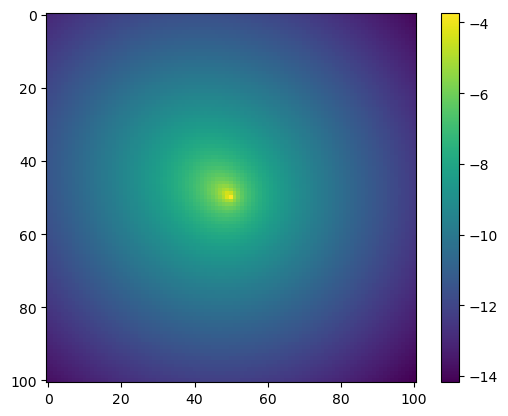

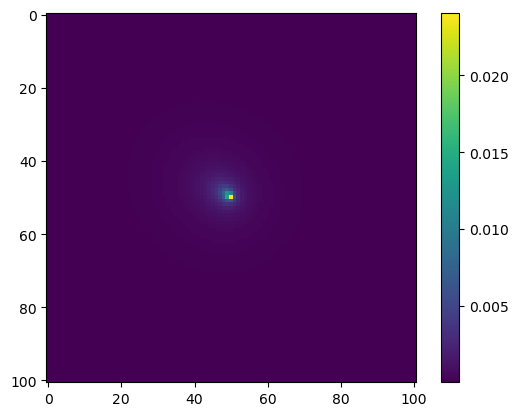

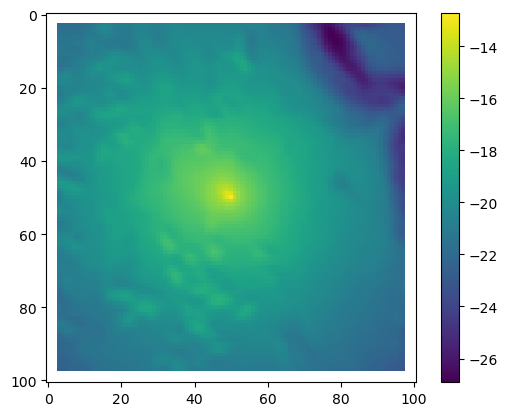

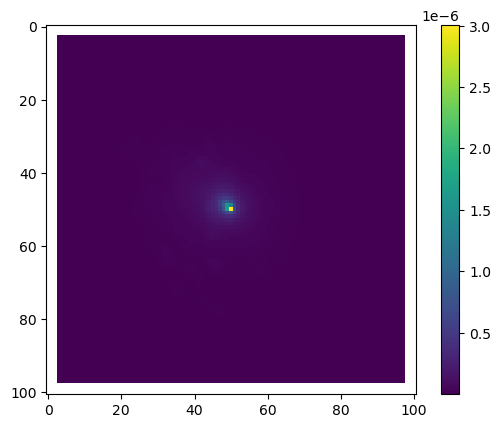

In [698]:
# Run model on covariates
test = model((x1, x2, x3))
print(test.shape)
# print(test)

# print(np.sum(np.exp(test.detach().numpy()[0,:,:,0])))

# plot the results of the habitat density as an image
hab_density = test.detach().numpy()[0,:,:,0]
hab_density_exp = np.exp(hab_density)

# Create the mask for x and y coordinates
x_mask = np.ones_like(hab_density)
y_mask = np.ones_like(hab_density)

# mask out cells on the edges that affect the colour scale
x_mask[:, :3] = -np.inf
x_mask[:, 98:] = -np.inf
y_mask[:3, :] = -np.inf
y_mask[98:, :] = -np.inf

hab_density_mask = hab_density * x_mask * y_mask
hab_density_exp_mask = hab_density_exp * x_mask * y_mask

# plot the results of the habitat density as an image - in log scale
filename_hab_log = f"outputs/step_probs_covs/id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}_habitat_log.png"
plt.imshow(hab_density_mask)
plt.colorbar()
plt.savefig(filename_hab_log, dpi=600, bbox_inches='tight')
plt.show()
plt.close()  # Close the figure to free memory

# plot the results of the habitat density as an image - as probabilities
filename_hab_exp = f"outputs/step_probs_covs/id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}_habitat_exp.png"
plt.imshow(hab_density_exp_mask)
plt.colorbar()
plt.savefig(filename_hab_exp, dpi=600, bbox_inches='tight')
plt.show()
plt.close() # Close the figure to free memory

# print(np.sum(np.exp(test.detach().numpy()[0,:,:,1])))

movement_density = test.detach().numpy()[0,:,:,1]
movement_density_exp = np.exp(movement_density)

# plot the results of the movement density as an image - in log scale
filename_move_log = f"outputs/step_probs_covs/id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}_move_log.png"
plt.imshow(movement_density)
plt.colorbar()
plt.savefig(filename_move_log, dpi=600, bbox_inches='tight')
plt.show()
plt.close()  # Close the figure to free memory

# plot the results of the movement density as an image - as probabilities
filename_move_exp = f"outputs/step_probs_covs/id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}_move_exp.png"
plt.imshow(movement_density_exp)
plt.colorbar()
plt.savefig(filename_move_exp, dpi=600, bbox_inches='tight')
plt.show()
plt.close()  # Close the figure to free memory

# print(np.sum(np.exp(test.detach().numpy()[0,:,:,1])))

step_density = test[0, :, :, 0] + test[0, :, :, 1]
step_density = step_density.detach().numpy()
step_density_exp = np.exp(step_density)

step_density_mask = step_density * x_mask * y_mask
step_density_exp_mask = step_density_exp * x_mask * y_mask

# results of the habitat and movement densities - log-scale
filename_step_log = f"outputs/step_probs_covs/id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}_step_log.png"
plt.imshow(step_density_mask)
plt.colorbar()
plt.savefig(filename_step_log, dpi=600, bbox_inches='tight')
plt.show()
plt.close()  # Close the figure to free memory

# exponentiated
filename_step_exp = f"outputs/step_probs_covs/id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}_step_exp.png"
plt.imshow(step_density_exp_mask)
plt.colorbar()
plt.savefig(filename_step_exp, dpi=600, bbox_inches='tight')
plt.show()
plt.close()  # Close the figure to free memory

### Adding hooks to check movement parameters

In [699]:
# Register hook to capture the output of FCN_block_all_movement
intermediate_output = []

def hook(module, input, output):
    intermediate_output.append(output)

hook_handle = model.fcn_movement_all.register_forward_hook(hook)

# Get the output from the full model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    final_output = model((x1, x2, x3))

# Print the intermediate output
print("Intermediate output shape:", intermediate_output[0].shape)
print("Intermediate output values:", intermediate_output[0][0])

# Remove hook
hook_handle.remove()

# gamma_shape1, gamma_scale1, gamma_weight1, gamma_shape2, gamma_scale2, gamma_weight2, vonmises_kappa1, vonmises_weight1, vonmises_kappa2, vonmises_weight2 = intermediate_output[0][0]
gamma_shape1, gamma_scale1, gamma_weight1, gamma_shape2, gamma_scale2, gamma_weight2, vonmises_mu1, vonmises_kappa1, vonmises_weight1, vonmises_mu2, vonmises_kappa2, vonmises_weight2 = intermediate_output[0][0]


# Gamma 1 parameters
print("Gamma shape 1:", torch.exp(gamma_shape1))
print("Gamma scale 1:", torch.exp(gamma_scale1))
print("Gamma weight 1:", torch.exp(gamma_weight1)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2)))

# Gamma 2 parameters
print("Gamma shape 2:", torch.exp(gamma_shape2))
print("Gamma scale 2:", torch.exp(gamma_scale2))
print("Gamma weight 2:", torch.exp(gamma_weight2)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2)))
      
# Von Mises 1 parameters
print("Von Mises mu 1:", vonmises_mu1 % (2*np.pi))
print("Von Mises kappa 1:", torch.exp(vonmises_kappa1))
print("Von Mises weight 1:", torch.exp(vonmises_weight1)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2)))
      
# Von Mises 2 parameters
print("Von Mises mu 2:", vonmises_mu2 % (2*np.pi))
print("Von Mises kappa 2:", torch.exp(vonmises_kappa2))
print("Von Mises weight 2:", torch.exp(vonmises_weight2)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2)))


Intermediate output shape: torch.Size([32, 12])
Intermediate output values: tensor([ 0.4099,  0.6910,  0.5276, -2.4754, -0.3783, -2.1834, -0.0434,  1.1445,
        -0.2038,  0.1975, -1.3307,  0.7228])
Gamma shape 1: tensor(1.5067)
Gamma scale 1: tensor(1.9957)
Gamma weight 1: tensor(0.9377)
Gamma shape 2: tensor(0.0841)
Gamma scale 2: tensor(0.6850)
Gamma weight 2: tensor(0.0623)
Von Mises mu 1: tensor(6.2398)
Von Mises kappa 1: tensor(3.1409)
Von Mises weight 1: tensor(0.2836)
Von Mises mu 2: tensor(0.1975)
Von Mises kappa 2: tensor(0.2643)
Von Mises weight 2: tensor(0.7164)


Plot the distributions

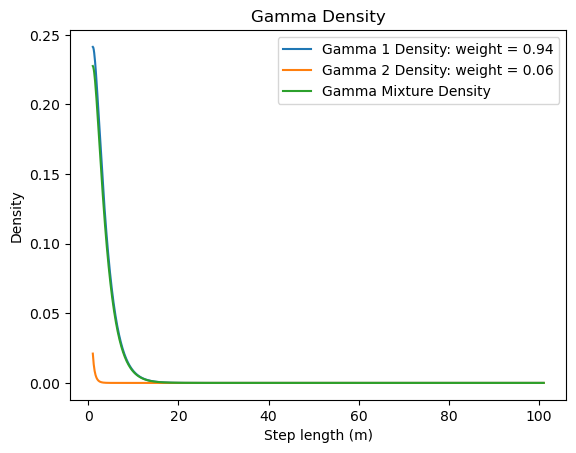

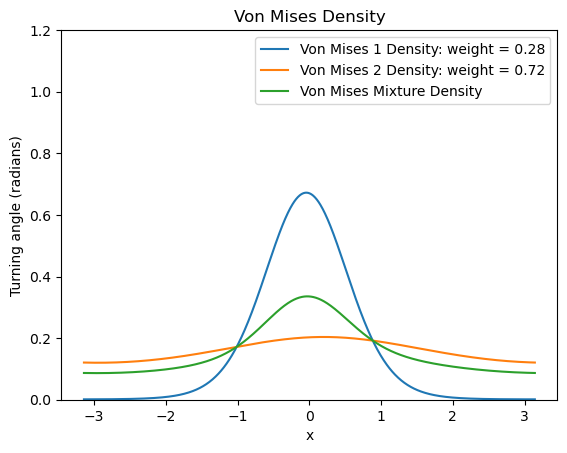

In [700]:
# Gamma densities for the mixture distribution
def gamma_density(x, shape, scale):
    return -1*torch.lgamma(shape) -shape*torch.log(scale) + (shape - 1)*torch.log(x) - x/scale

# von Mises densities for the mixture distribution
def vonmises_density(x, kappa, vm_mu):
    return kappa*torch.cos(x - vm_mu) - 1*(np.log(2*torch.pi) + torch.log(torch.special.i0(kappa)))


# Round the weight variables
# Gamma weights
gamma_weight1_recovered = torch.exp(gamma_weight1)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))
rounded_gamma_weight1 = round(gamma_weight1_recovered.item(), 2)
gamma_weight2_recovered = torch.exp(gamma_weight2)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))
rounded_gamma_weight2 = round(gamma_weight2_recovered.item(), 2)

# von Mises weights
vonmises_weight1_recovered = torch.exp(vonmises_weight1)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))
rounded_vm_weight1 = round(vonmises_weight1_recovered.item(), 2)
vonmises_weight2_recovered = torch.exp(vonmises_weight2)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))
rounded_vm_weight2 = round(vonmises_weight2_recovered.item(), 2)


# parameters of the Gamma mixture distributions
# Generate x values (metres)
x_values = torch.linspace(1, 101, 1000)
gamma1_density = gamma_density(x_values, torch.exp(gamma_shape1), torch.exp(gamma_scale1))
gamma2_density = gamma_density(x_values, torch.exp(gamma_shape2), torch.exp(gamma_scale2))
gamma_mixture_density = gamma_weight1_recovered*torch.exp(gamma1_density) + gamma_weight2_recovered*torch.exp(gamma2_density)

# Plot the gamma density function
filename_gamma = f"outputs/step_probs_covs/id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}_gamma.png"
plt.plot(x_values.numpy(), np.exp(gamma1_density.numpy()), label=f'Gamma 1 Density: weight = {rounded_gamma_weight1}')
plt.plot(x_values.numpy(), np.exp(gamma2_density.numpy()), label=f'Gamma 2 Density: weight = {rounded_gamma_weight2}')
plt.plot(x_values.numpy(), gamma_mixture_density.numpy(), label='Gamma Mixture Density')
# plt.xscale('log')
plt.xlabel('Step length (m)')
plt.ylabel('Density')
plt.title('Gamma Density')
plt.legend()
plt.savefig(filename_gamma, dpi=600, bbox_inches='tight')
plt.show()
plt.close()  # Close the figure to free memory

# parameters of the von mises mixture distribution
# Generate x values from -pi to pi
x_values = torch.linspace(-np.pi, np.pi, 1000)
vonmises1_density = vonmises_density(x_values, torch.exp(vonmises_kappa1), vonmises_mu1)
vonmises2_density = vonmises_density(x_values, torch.exp(vonmises_kappa2), vonmises_mu2)
vonmises_mixture_density = vonmises_weight1_recovered*torch.exp(vonmises1_density) + vonmises_weight2_recovered*torch.exp(vonmises2_density)

# Plot the von mises density function
filename_vonmises = f"outputs/step_probs_covs/id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}_vonmises.png"
plt.plot(x_values.numpy(), np.exp(vonmises1_density.numpy()), label=f'Von Mises 1 Density: weight = {rounded_vm_weight1}')
plt.plot(x_values.numpy(), np.exp(vonmises2_density.numpy()), label=f'Von Mises 2 Density: weight = {rounded_vm_weight2}')
plt.plot(x_values.numpy(), vonmises_mixture_density.numpy(), label='Von Mises Mixture Density')
plt.xlabel('x')
plt.ylabel('Turning angle (radians)')
plt.title('Von Mises Density')
plt.ylim(0, 1.2)  # Set the y-axis limits from 0 to 0.2
plt.legend()
plt.savefig(filename_vonmises, dpi=600, bbox_inches='tight')
plt.show()
plt.close()  # Close the figure to free memory

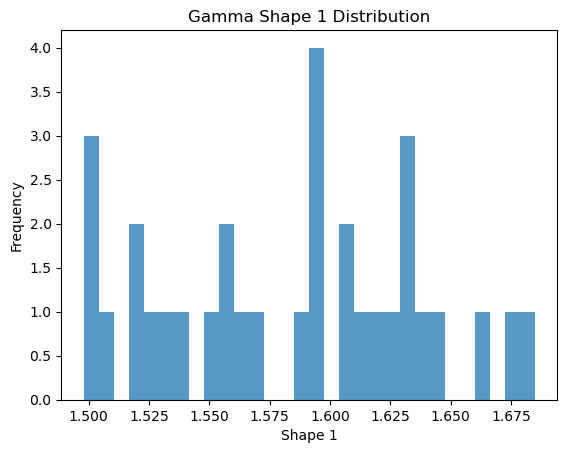

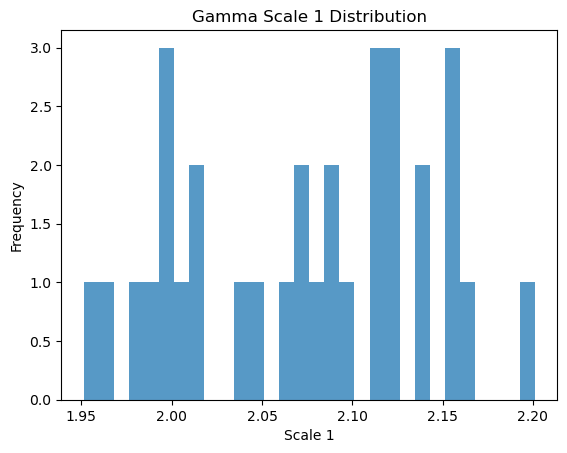

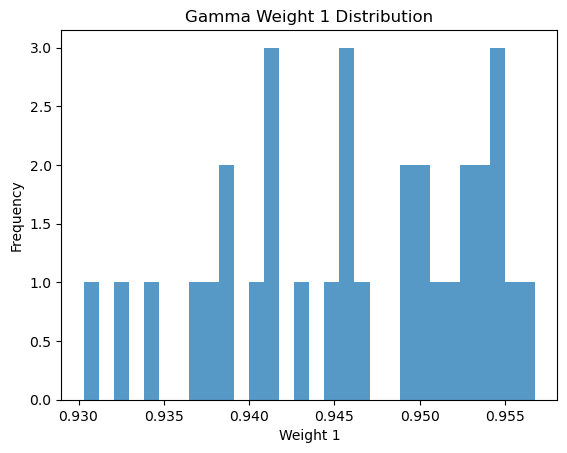

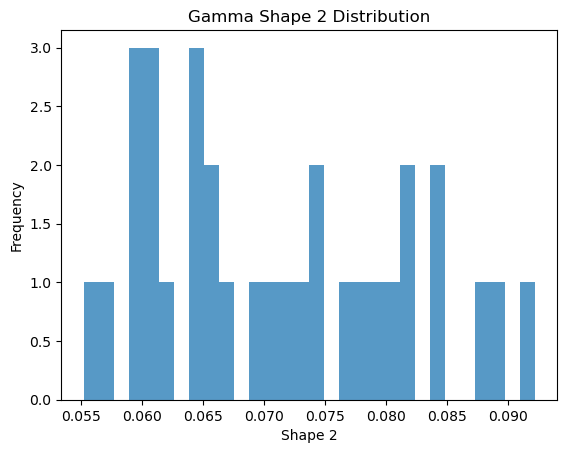

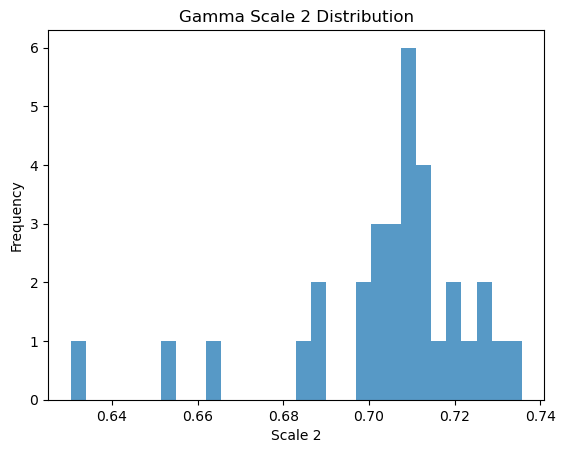

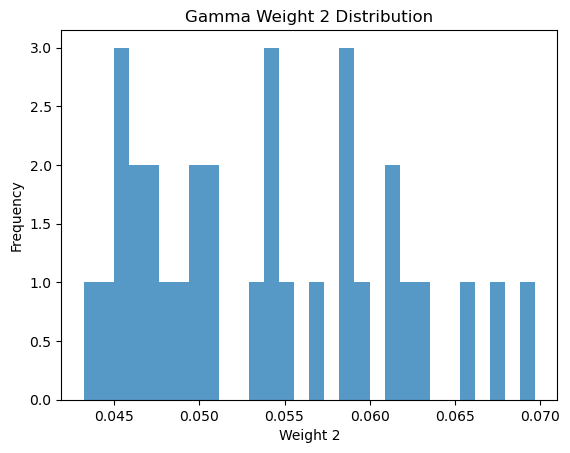

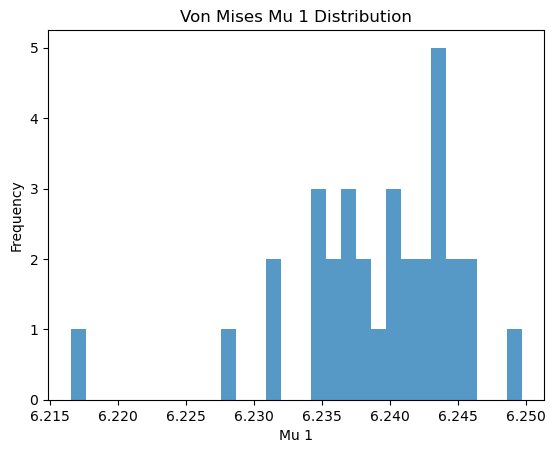

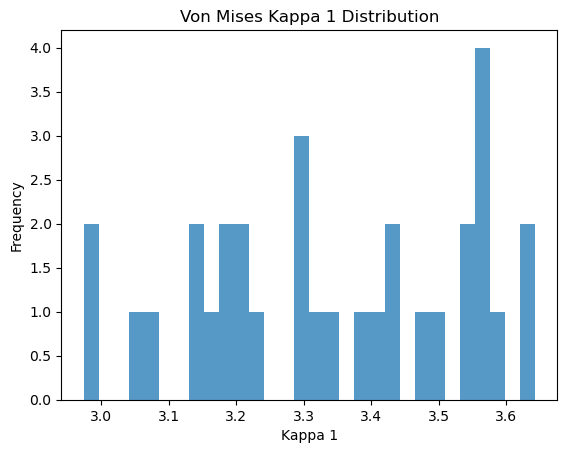

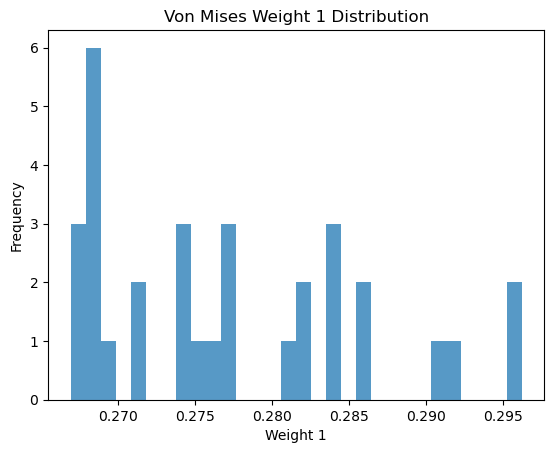

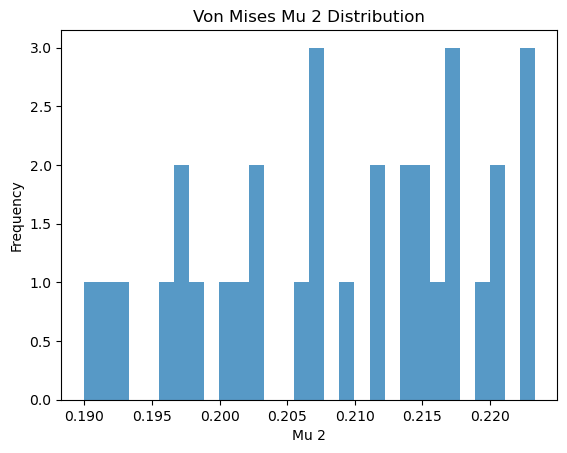

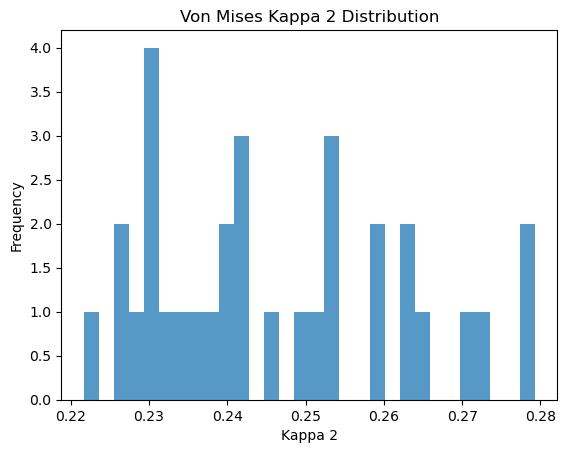

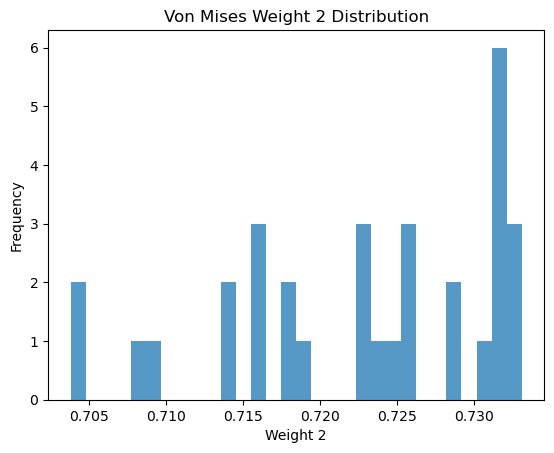

In [701]:
# Register hook to capture the output of FCN_block_all_movement
intermediate_output = []

def hook(module, input, output):
    intermediate_output.append(output)

hook_handle = model.fcn_movement_all.register_forward_hook(hook)

# Get the output from the full model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    final_output = model((x1, x2, x3))

# Extract parameters for each batch
gamma_shape1_list = []
gamma_scale1_list = []
gamma_weight1_list = []
gamma_shape2_list = []
gamma_scale2_list = []
gamma_weight2_list = []
vonmises_mu1_list = []
vonmises_kappa1_list = []
vonmises_weight1_list = []
vonmises_mu2_list = []
vonmises_kappa2_list = []
vonmises_weight2_list = []

for batch_output in intermediate_output:
    for sample_output in batch_output:
        gamma_shape1, gamma_scale1, gamma_weight1, gamma_shape2, gamma_scale2, gamma_weight2, vonmises_mu1, vonmises_kappa1, vonmises_weight1, vonmises_mu2, vonmises_kappa2, vonmises_weight2 = sample_output
        # gamma_shape1, gamma_scale1, gamma_weight1, gamma_shape2, gamma_scale2, gamma_weight2, vonmises_kappa1, vonmises_weight1, vonmises_kappa2, vonmises_weight2 = sample_output

        gamma_shape1_list.append(torch.exp(gamma_shape1).item())
        gamma_scale1_list.append(torch.exp(gamma_scale1).item())
        gamma_weight1_list.append((torch.exp(gamma_weight1)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))).item())
        gamma_shape2_list.append(torch.exp(gamma_shape2).item())
        gamma_scale2_list.append(torch.exp(gamma_scale2).item())
        gamma_weight2_list.append((torch.exp(gamma_weight2)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))).item())
        vonmises_mu1_list.append((vonmises_mu1 % (2*np.pi)).item())
        vonmises_kappa1_list.append(torch.exp(vonmises_kappa1).item())
        vonmises_weight1_list.append((torch.exp(vonmises_weight1)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))).item())
        vonmises_mu2_list.append((vonmises_mu2 % (2*np.pi)).item())
        vonmises_kappa2_list.append(torch.exp(vonmises_kappa2).item())
        vonmises_weight2_list.append((torch.exp(vonmises_weight2)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))).item())

# Plot parameters
def plot_histogram(data, title, xlabel):
    plt.figure()
    plt.hist(data, bins=30, alpha=0.75)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.show()

plot_histogram(gamma_shape1_list, 'Gamma Shape 1 Distribution', 'Shape 1')
plot_histogram(gamma_scale1_list, 'Gamma Scale 1 Distribution', 'Scale 1')
plot_histogram(gamma_weight1_list, 'Gamma Weight 1 Distribution', 'Weight 1')
plot_histogram(gamma_shape2_list, 'Gamma Shape 2 Distribution', 'Shape 2')
plot_histogram(gamma_scale2_list, 'Gamma Scale 2 Distribution', 'Scale 2')
plot_histogram(gamma_weight2_list, 'Gamma Weight 2 Distribution', 'Weight 2')
plot_histogram(vonmises_mu1_list, 'Von Mises Mu 1 Distribution', 'Mu 1')
plot_histogram(vonmises_kappa1_list, 'Von Mises Kappa 1 Distribution', 'Kappa 1')
plot_histogram(vonmises_weight1_list, 'Von Mises Weight 1 Distribution', 'Weight 1')
plot_histogram(vonmises_mu2_list, 'Von Mises Mu 2 Distribution', 'Mu 2')
plot_histogram(vonmises_kappa2_list, 'Von Mises Kappa 2 Distribution', 'Kappa 2')
plot_histogram(vonmises_weight2_list, 'Von Mises Weight 2 Distribution', 'Weight 2')

# Remove hook
hook_handle.remove()

tensor([[[-13.7686, -13.7034, -13.6386,  ..., -12.9281, -12.9911, -13.0547],
         [-13.7127, -13.6468, -13.5814,  ..., -12.8691, -12.9330, -12.9974],
         [-13.6574, -13.5909, -13.5247,  ..., -12.8108, -12.8756, -12.9409],
         ...,
         [-14.0698, -14.0090, -13.9487,  ..., -13.7812, -13.8391, -13.8976],
         [-14.1310, -14.0708, -14.0112,  ..., -13.8461, -13.9033, -13.9611],
         [-14.1926, -14.1331, -14.0742,  ..., -13.9114, -13.9679, -14.0251]]],
       dtype=torch.float64)
torch.Size([1, 101, 101])


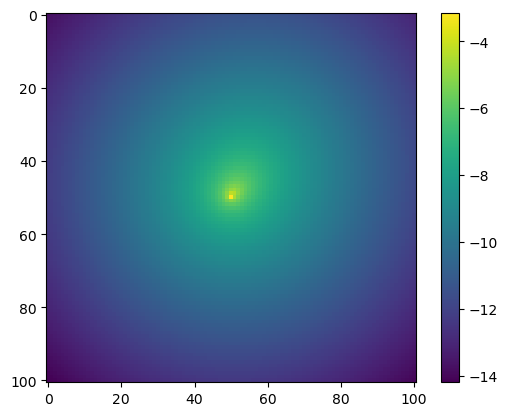

In [702]:
test_bearing = torch.tensor([[1.0]], device=device)

test_block = Params_to_Grid_Block(params)
# movement_density = test_block(torch.rand(1, 4, device=device))
# provide a tensor of shape (batch_size, 4) where the 4 columns are the parameters of the gamma and von mises distributions
# providing values in log space as the values are exponentiated in the forward pass
# movement_density = test_block(torch.tensor([[np.log(0.5), np.log(200), np.log(0.25), # gamma 1 - shape, scale and weight
#                                              np.log(2.5), np.log(300), np.log(0.75), # gamma 2 - shape, scale and weight
#                                              5, np.log(1), np.log(0.75),
#                                              -10, np.log(1.5), np.log(0.25)]], device=device), test_bearing)

movement_density = test_block(intermediate_output[0][0].unsqueeze(dim = 0), test_bearing)
# providing values as the model sees them
# movement_density = test_block(torch.tensor([[-.5, -.5, -.5, -.5]], device=device))
print(movement_density)
print(movement_density.shape)

# plot the results of the movement density as an image
plt.imshow(movement_density[0])
plt.colorbar()
plt.show()

### Visualise CNN layers

In [703]:
# Visualize the intermediate activations
# for layer_name, activation in activations.items():
#     print(f'Layer: {layer_name}, Shape: {activation.shape}')
#     plt.imshow(activation[0, 0].cpu().numpy(), cmap='gray')
#     plt.title(layer_name)
#     plt.show()